<a href="https://colab.research.google.com/github/theclosedbook/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
#Print Tf Version
print(tf.__version__)

2.15.0


In [3]:
## Loading and preprocessing the dataset
(X_train,y_train),(_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#Shape of X_train
X_train.shape

(60000, 28, 28)

In [5]:
#Shape of y_train
y_train.shape

(60000,)

25515
9


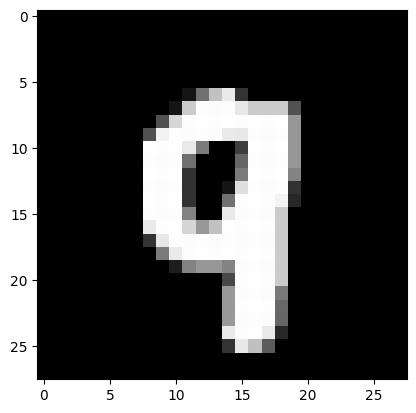

In [6]:
# To Visualize X_train and y_train
i = np.random.randint(0,60000)
print(i)
print(y_train[i])
plt.imshow(X_train[i],cmap='gray')

In [7]:
# Reshaping X_train
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [8]:
#Shape Of the resized X_train
X_train.shape

(60000, 28, 28, 1)

In [9]:
#Min and Max Value (Normalization Needed)
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

In [10]:
X_train = (X_train - 127.5) / 127.5

In [11]:
X_train[0].min(),X_train[0].max()

(-1.0, 1.0)

In [12]:
buffer_size = 60000
batch_size = 256

In [13]:
#Coneverting from np to tensors
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [14]:
#X_train info after converting into tensor
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

##Building Generator

In [48]:
# 100 -> 12544
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 256, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=False, activation='tanh'))

  network.summary()

  return network


In [49]:
# Summary of the generator
generator = build_generator()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_14 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_14 (Conv2  (None, 7, 7, 256)         1638400   
 DTranspose)                                                     
                                                                 
 batch_normalization_15 (Ba  (None, 7, 7, 256)        

In [50]:
# Input of the generator
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_6_input')>

In [51]:
# Random Noise
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.4204763 , -0.859345  , -1.2899514 ,  0.5067606 , -1.1049169 ,
        -0.6279825 , -1.3370795 ,  0.7156965 ,  1.3983339 ,  0.13416092,
         0.18985073, -0.4899584 , -1.2262365 ,  0.03913658,  0.8658341 ,
         1.4807788 ,  1.561266  ,  0.7831101 , -1.5538356 , -1.4295212 ,
         0.3316066 , -0.7690199 , -0.4617144 ,  2.3866117 ,  0.86502427,
        -1.811651  ,  0.06872781,  1.9206871 ,  0.36133638,  0.07105559,
        -0.78899884,  0.18479839, -0.3579661 ,  1.4664654 , -0.73988056,
         0.43859404,  0.5644698 , -0.9688511 ,  0.49389583, -0.29427367,
         1.52013   ,  0.30439836,  0.27136084, -0.27847064, -0.26511025,
        -0.7809238 , -1.0489494 , -0.13970579,  0.18294097,  0.15177129,
         0.50666595,  1.0418396 , -1.1088629 ,  0.26026714, -0.95471793,
         1.2411808 , -0.9748405 ,  0.5863771 , -2.489187  ,  0.26051983,
        -0.6064644 ,  0.45104182, -0.5703574 , -0.2114202 , -0.98499054,
 

In [52]:
generated_image = generator(noise,training = False)

In [53]:
generated_image.shape

TensorShape([1, 28, 28, 1])

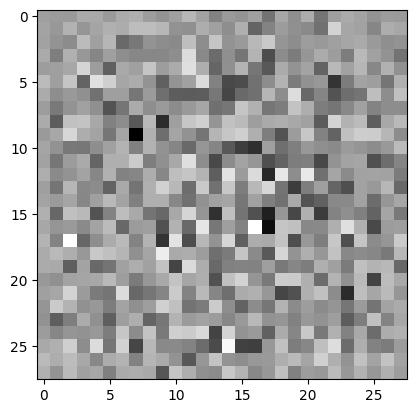

In [54]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [55]:
#Building the generator
def build_discriminator():
  network = tf.keras.Sequential()

  #14x14x64
  network.add(layers.Conv2D(filters=32,strides=(2,2),kernel_size=(5,5),padding = 'same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  #14x14x64
  network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(filters=128,strides=(2,2),kernel_size=(5,5),padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [56]:
# Discriminator Summary
discriminator = build_discriminator()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)        

In [57]:
# input of the discriminator
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_5_input')>

In [58]:
#Check for the noise i.e generated image
discriminator(generated_image,training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-7.330236e-05]], dtype=float32)>

In [59]:
# Checking the probability of the answer (closer to 1 = real)
tf.sigmoid(0.00039913)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5000998>

## Error Calculation

In [60]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [61]:
# Building discriminator loss

def discriminator_loss(expected_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss

  return total_loss


In [62]:
# Building the Generator loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [63]:
# generator_optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [64]:
# discriminator_optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

## Training The GAN

In [32]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [65]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [66]:
batch_size,noise_dimension

(256, 100)

In [67]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [68]:
test_images = tf.random.normal([number_of_images,noise_dimension])
test_images.shape

TensorShape([16, 100])

In [69]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


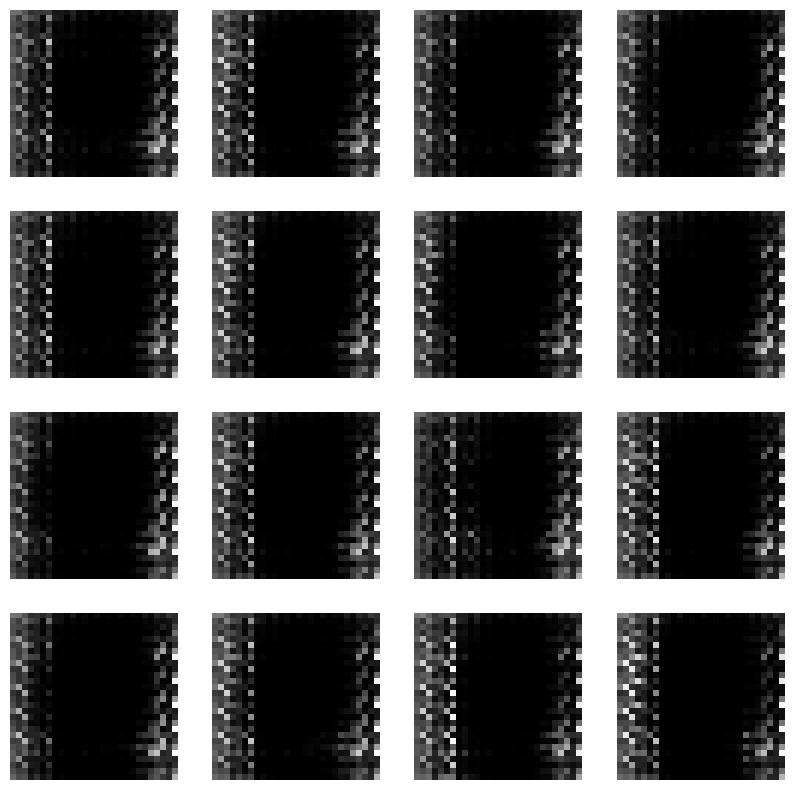

Epoch:  2


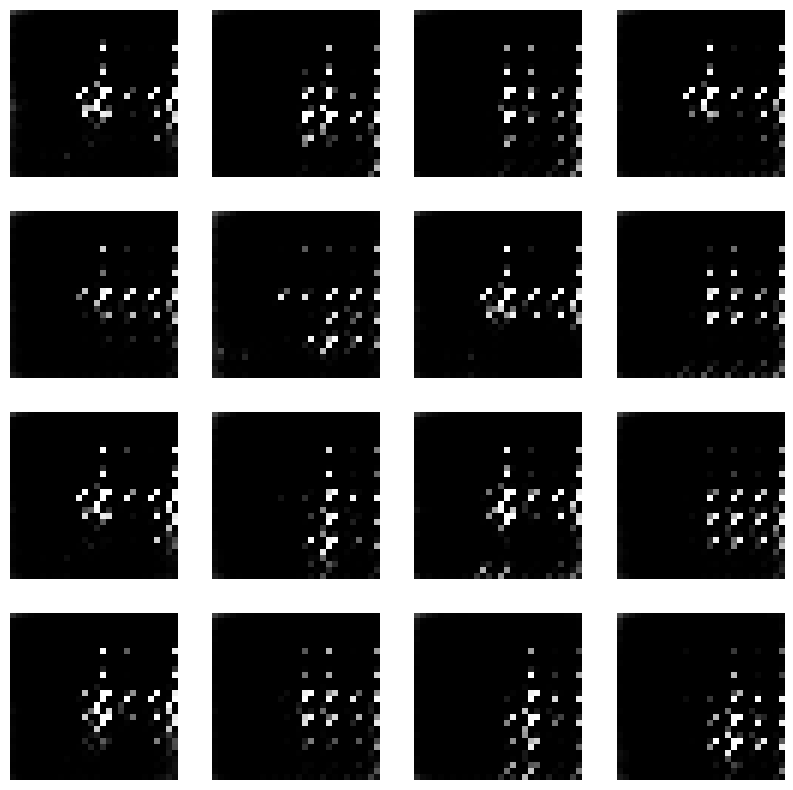

Epoch:  3


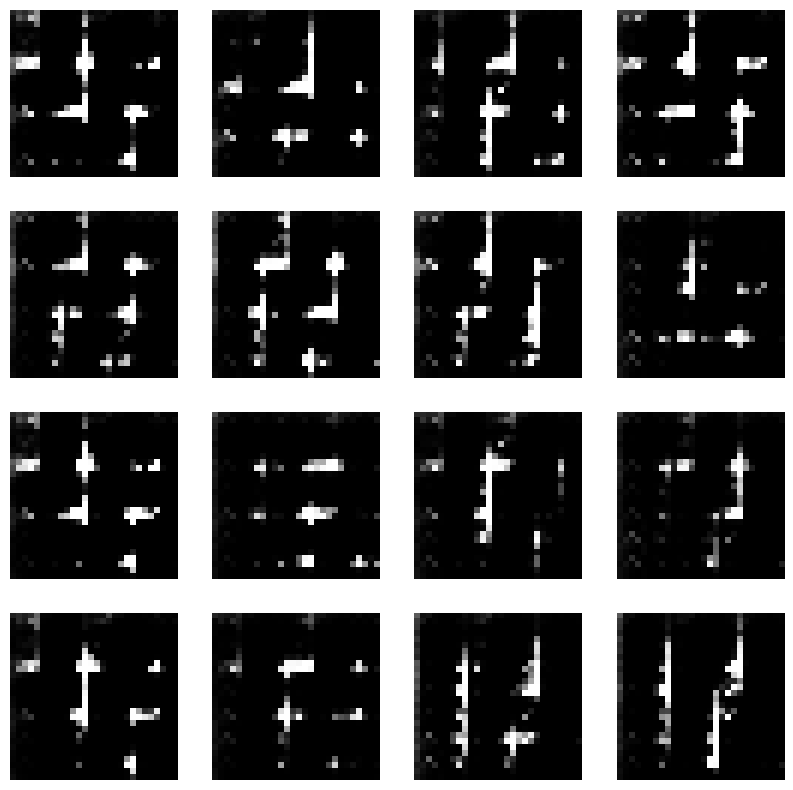

Epoch:  4


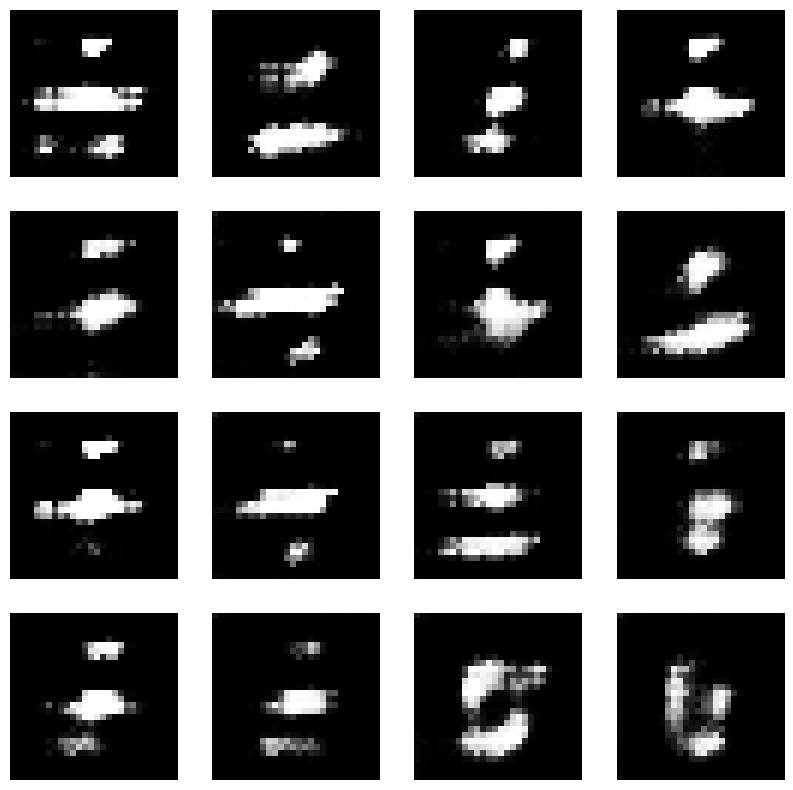

Epoch:  5


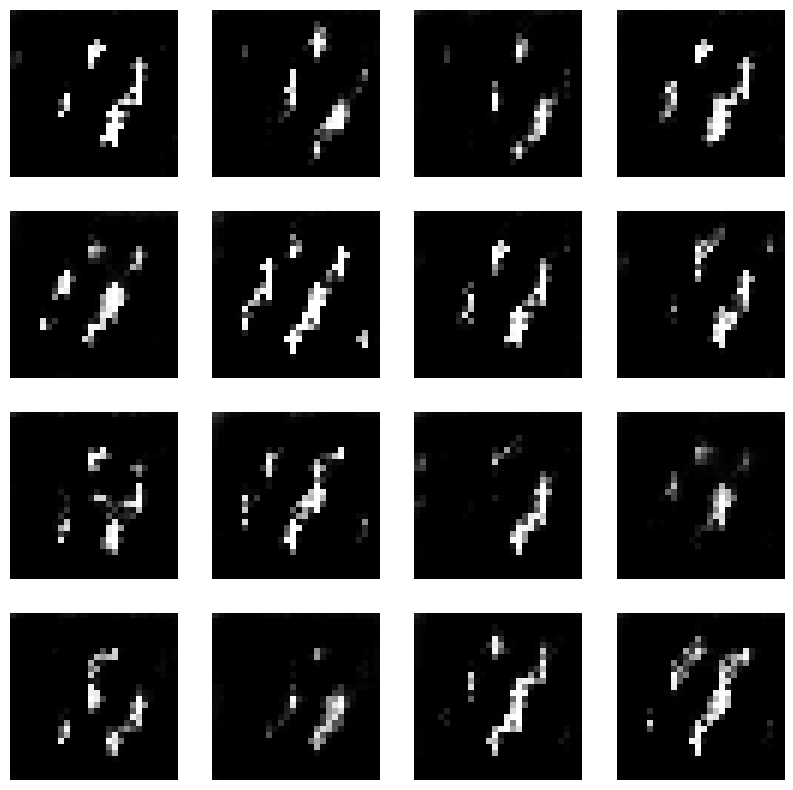

Epoch:  6


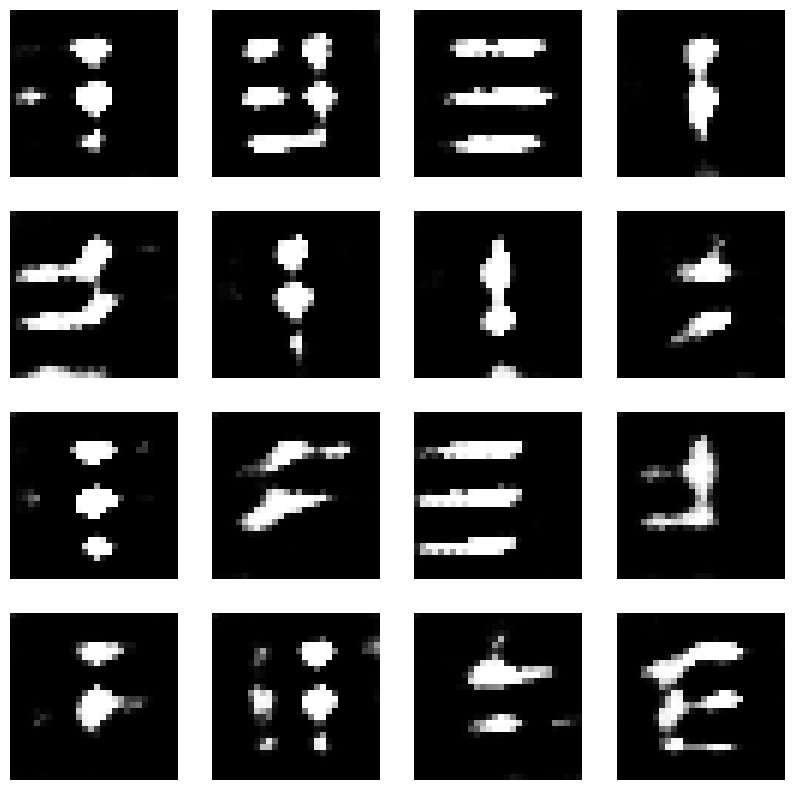

Epoch:  7


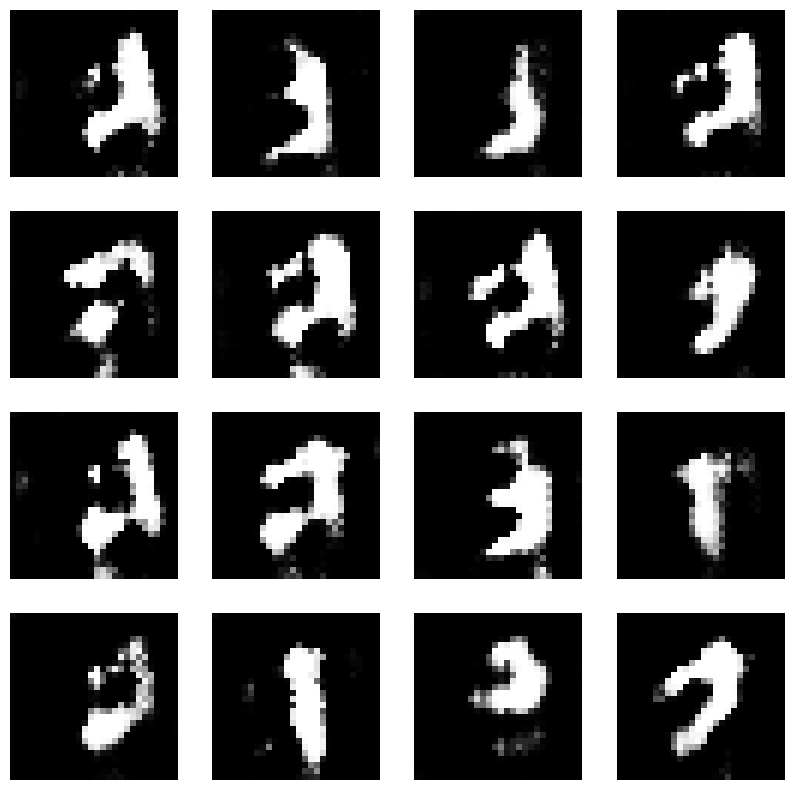

Epoch:  8


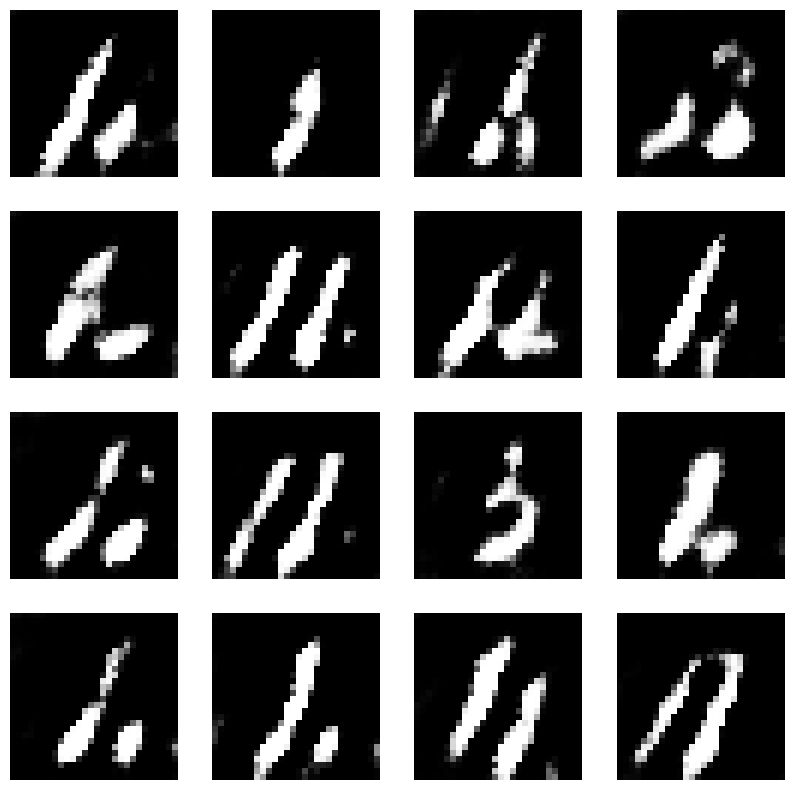

Epoch:  9


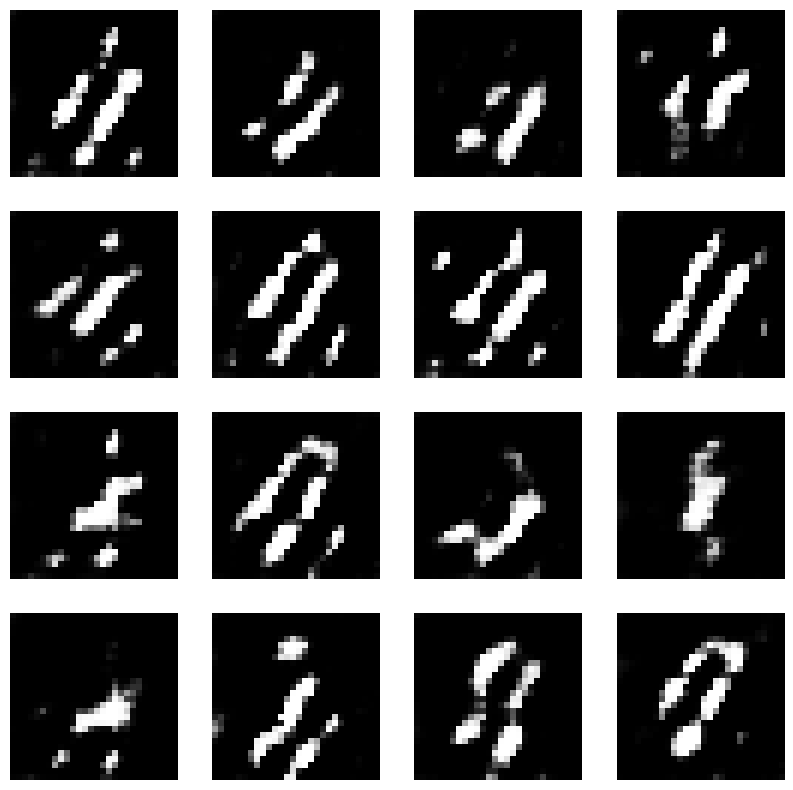

Epoch:  10


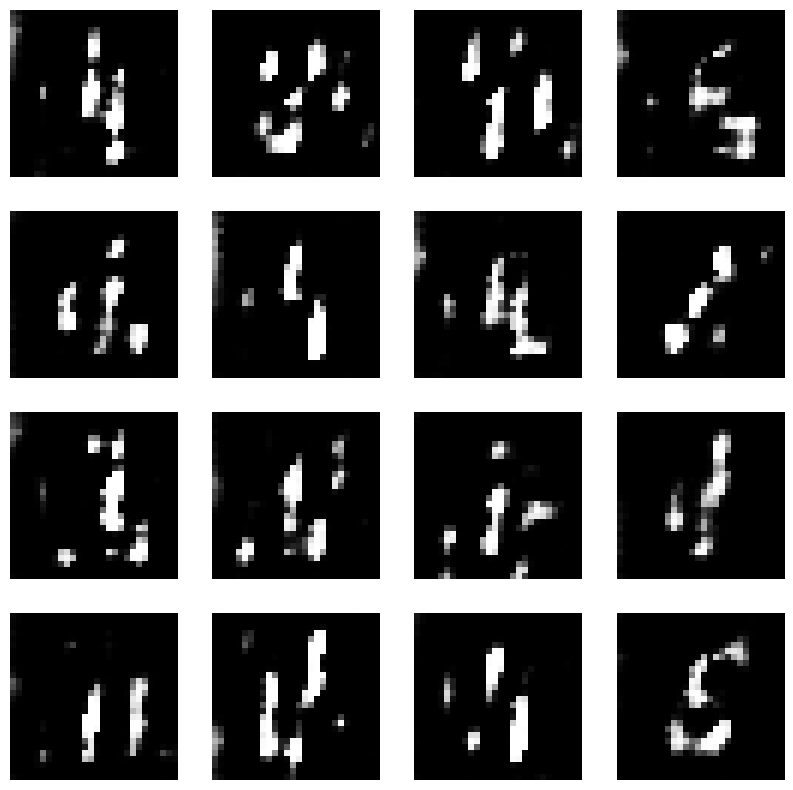

Epoch:  11


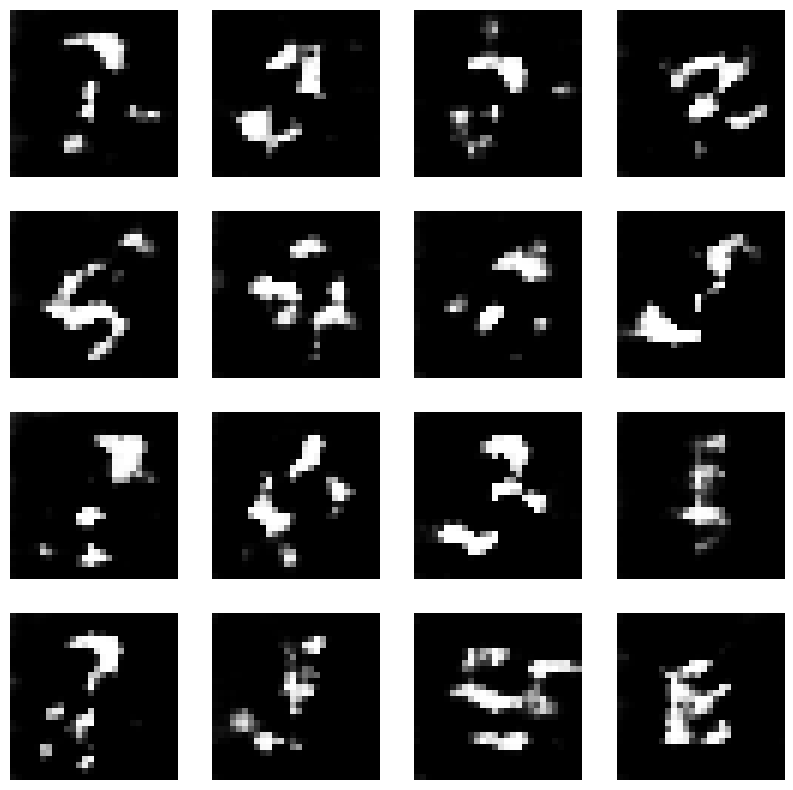

Epoch:  12


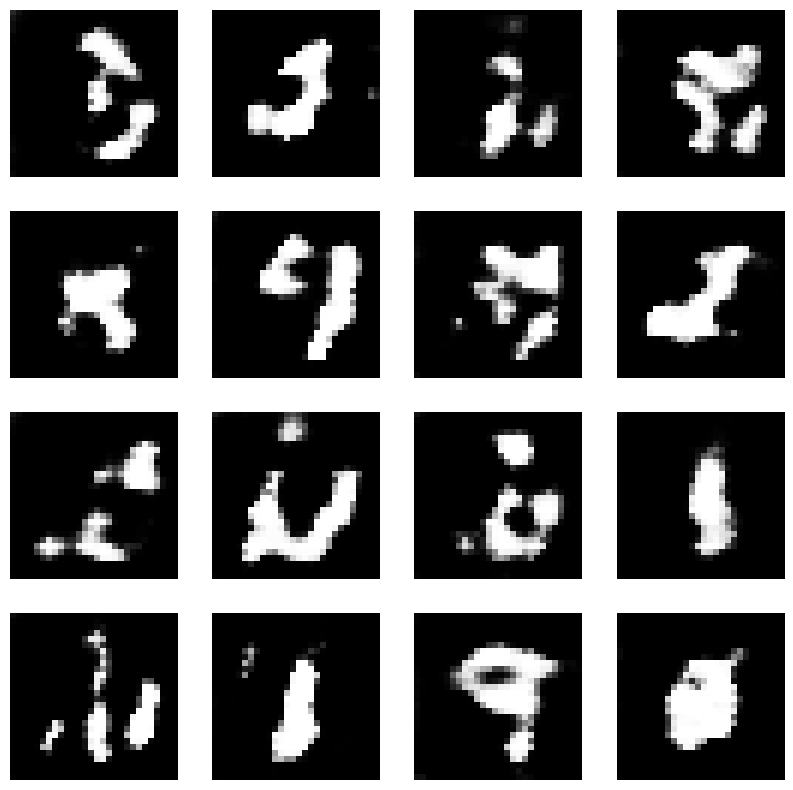

Epoch:  13


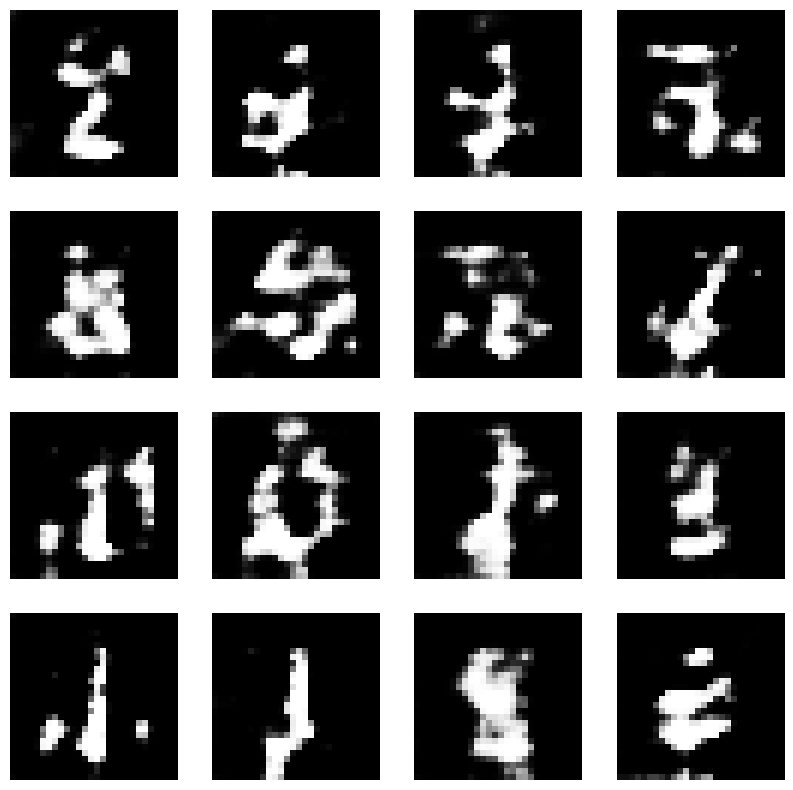

Epoch:  14


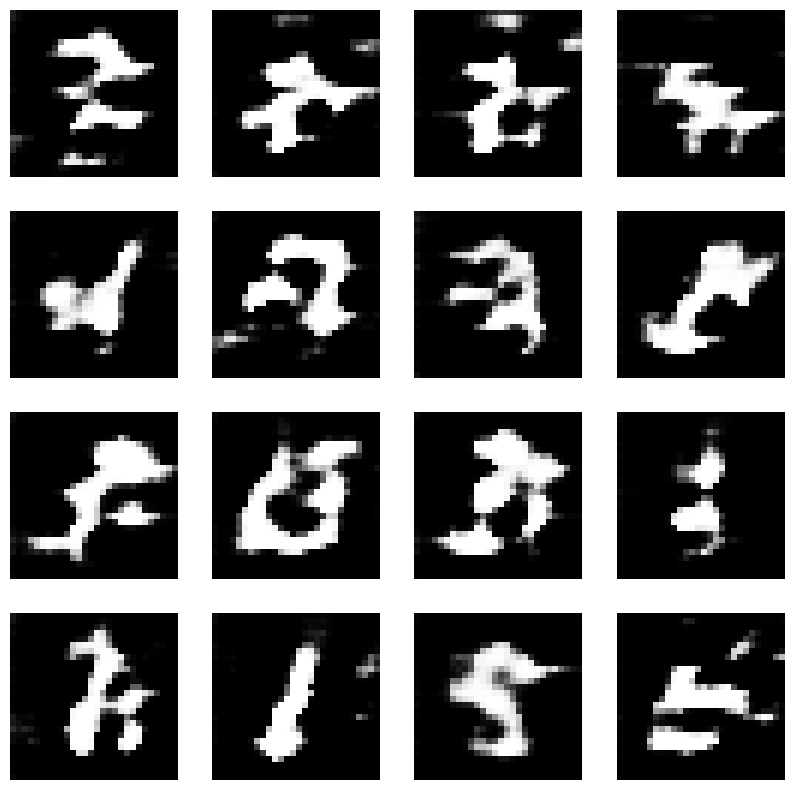

Epoch:  15


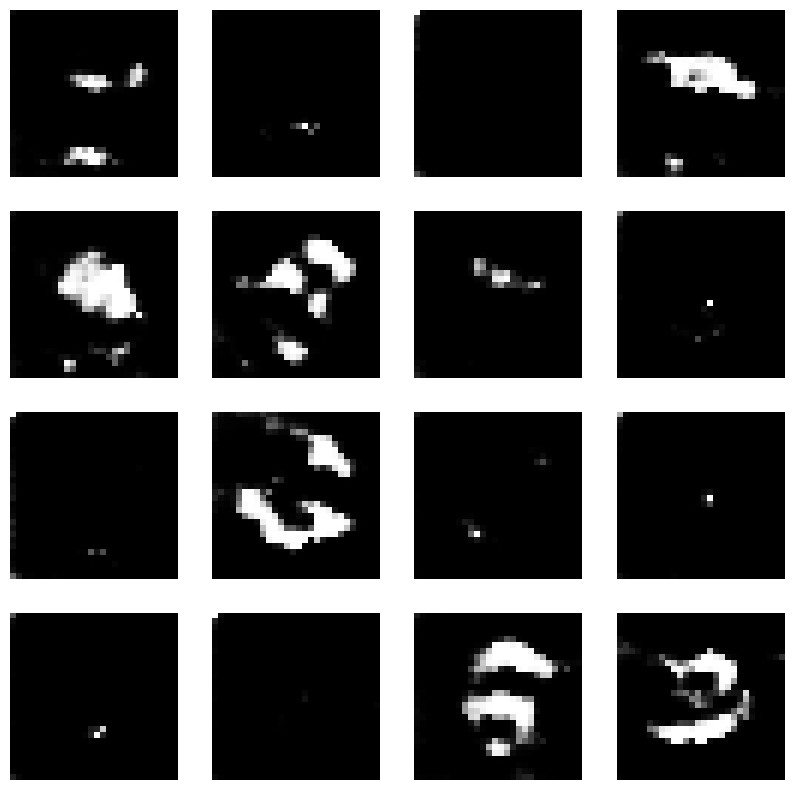

Epoch:  16


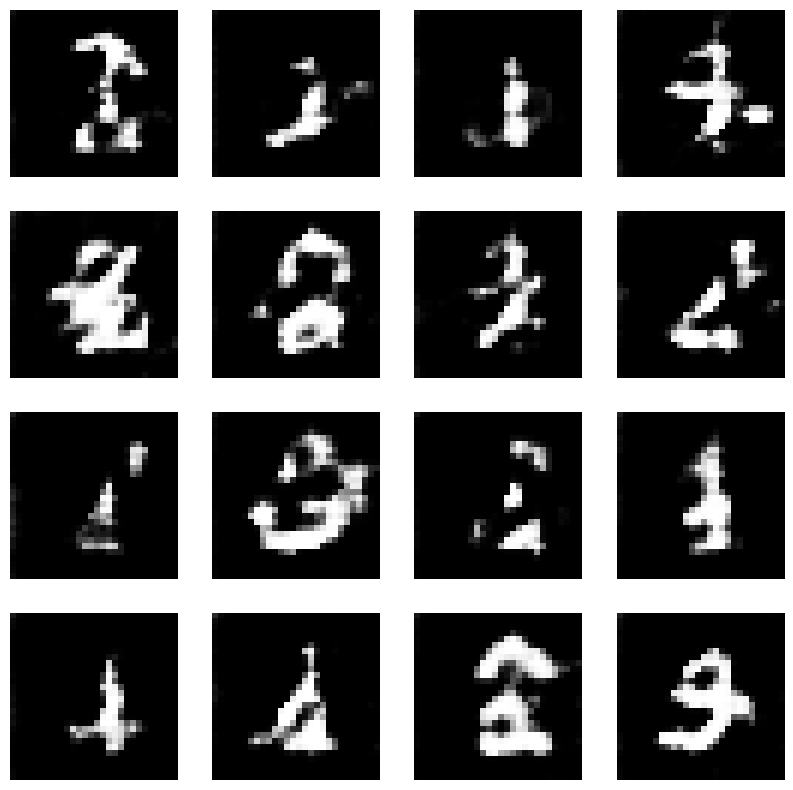

Epoch:  17


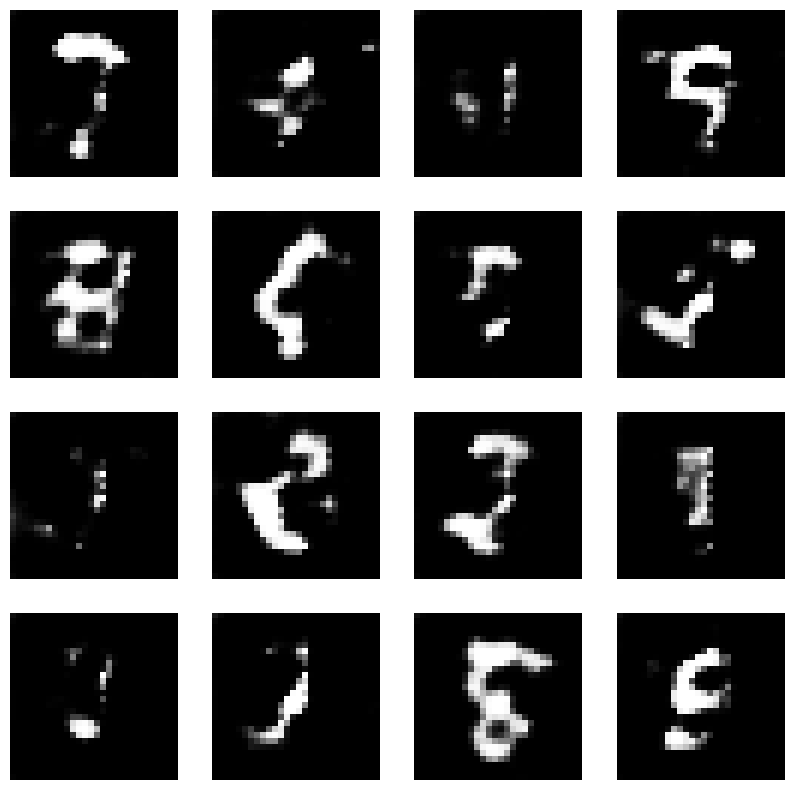

Epoch:  18


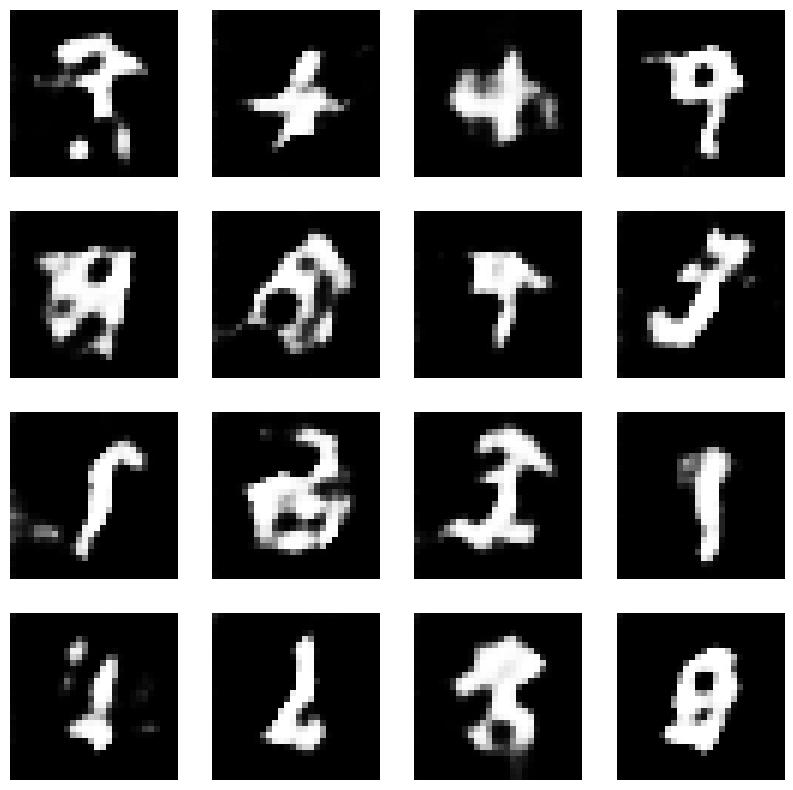

Epoch:  19


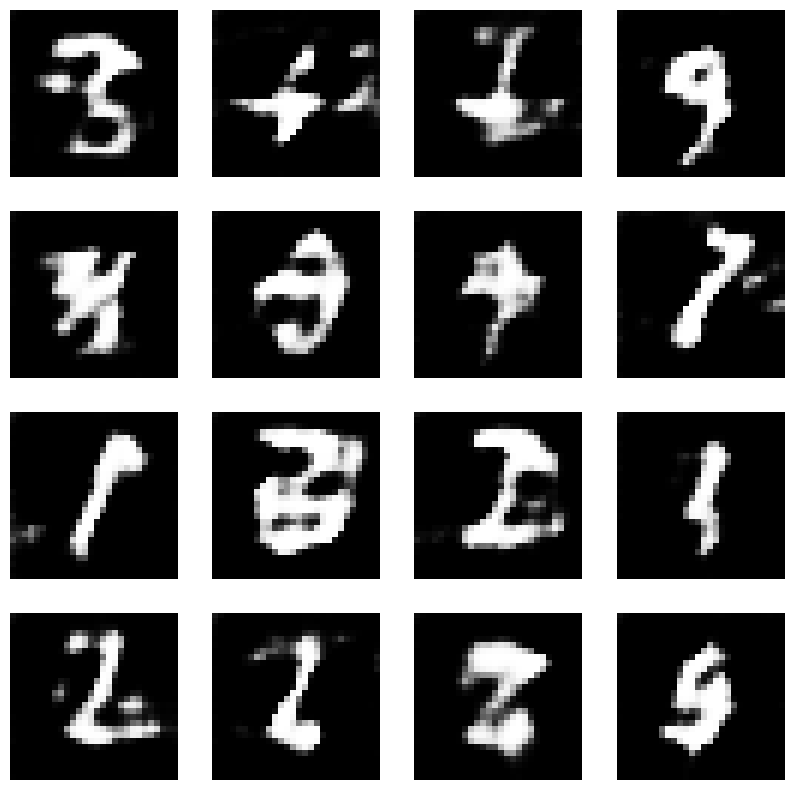

Epoch:  20


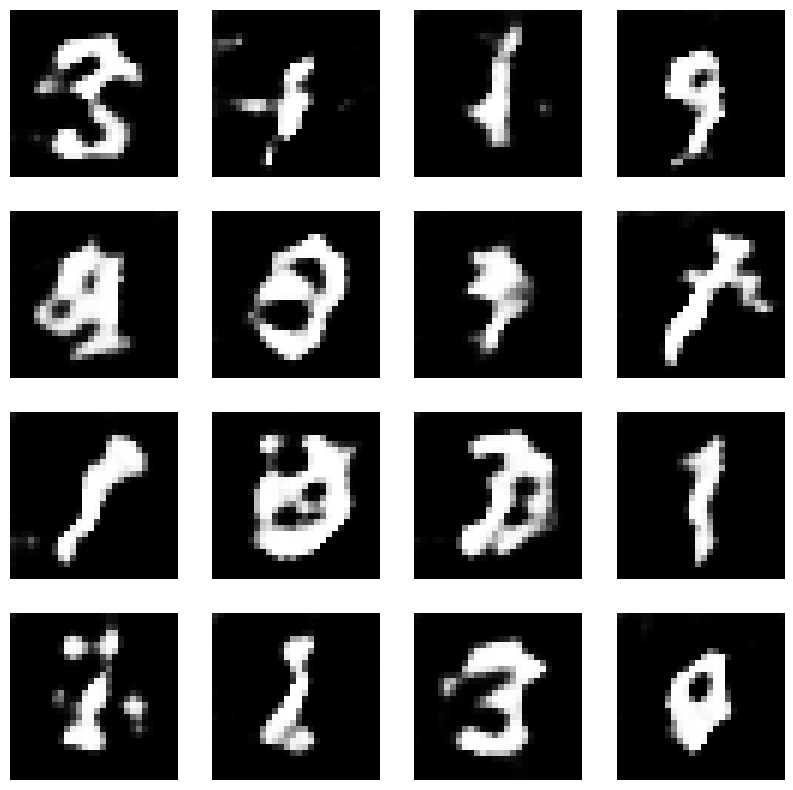

Epoch:  21


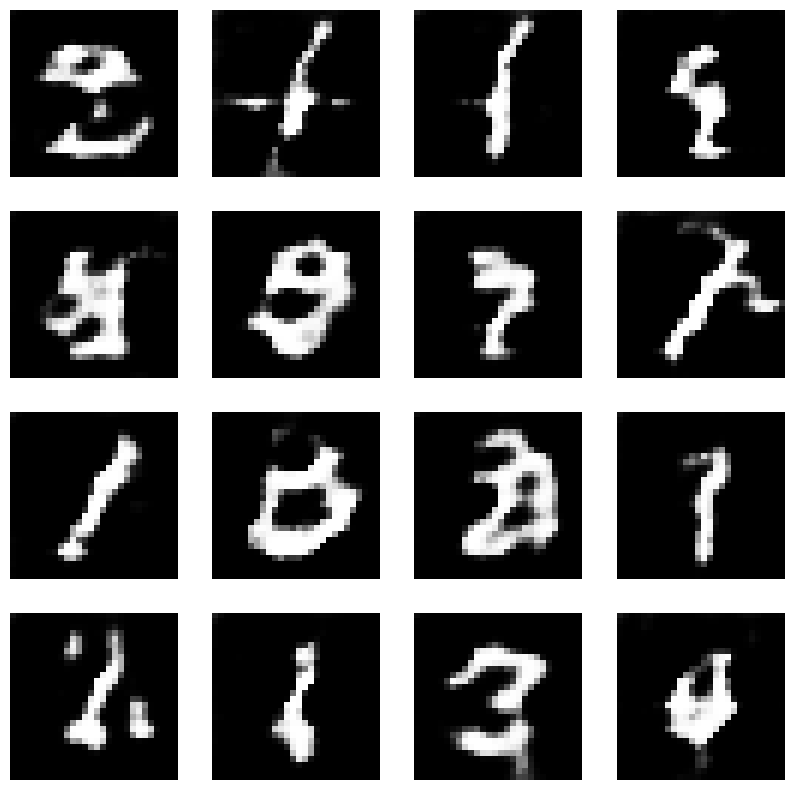

Epoch:  22


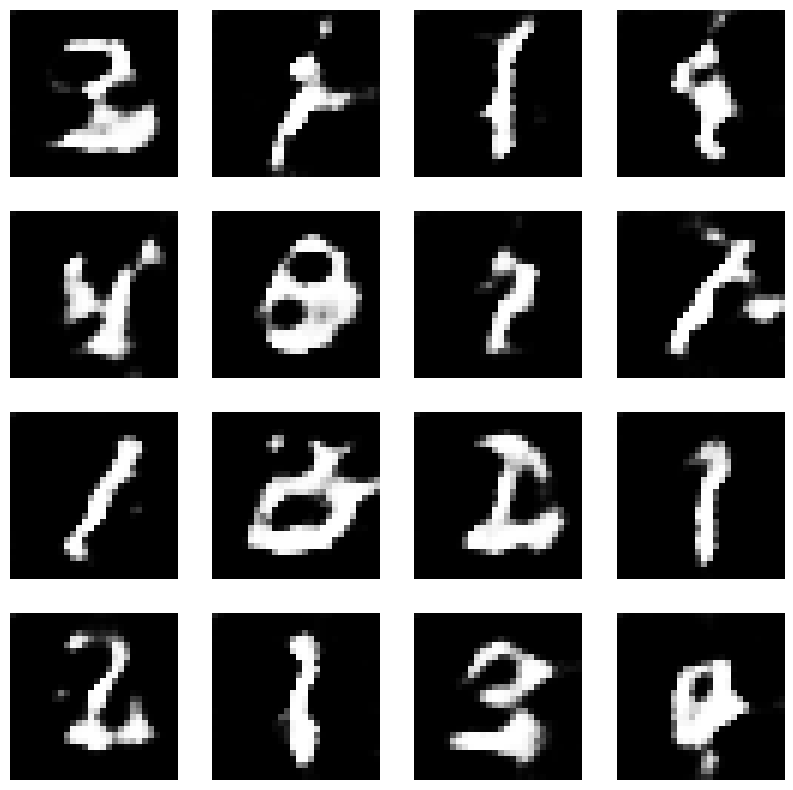

Epoch:  23


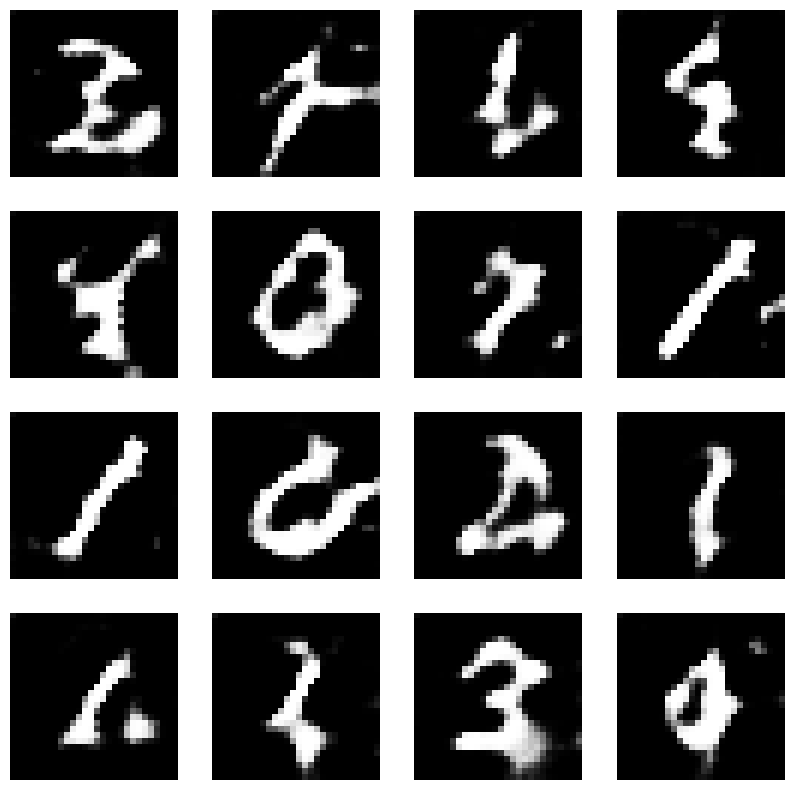

Epoch:  24


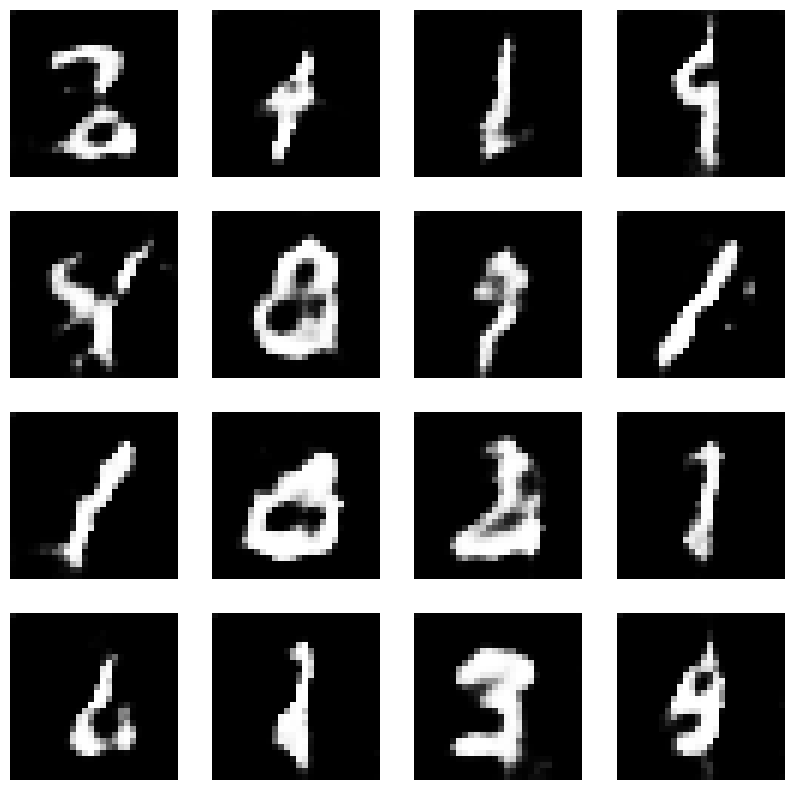

Epoch:  25


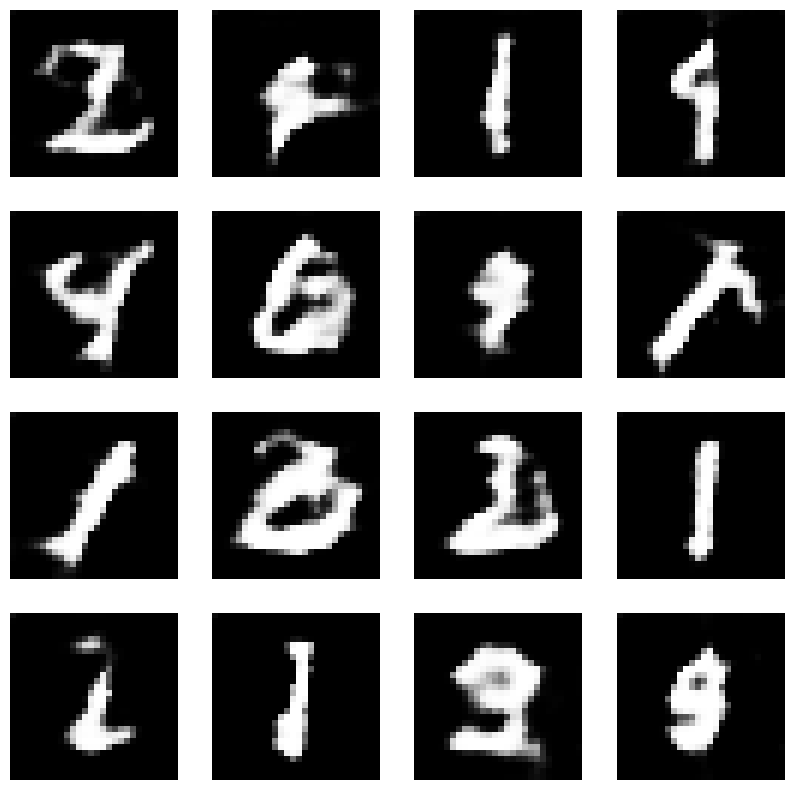

Epoch:  26


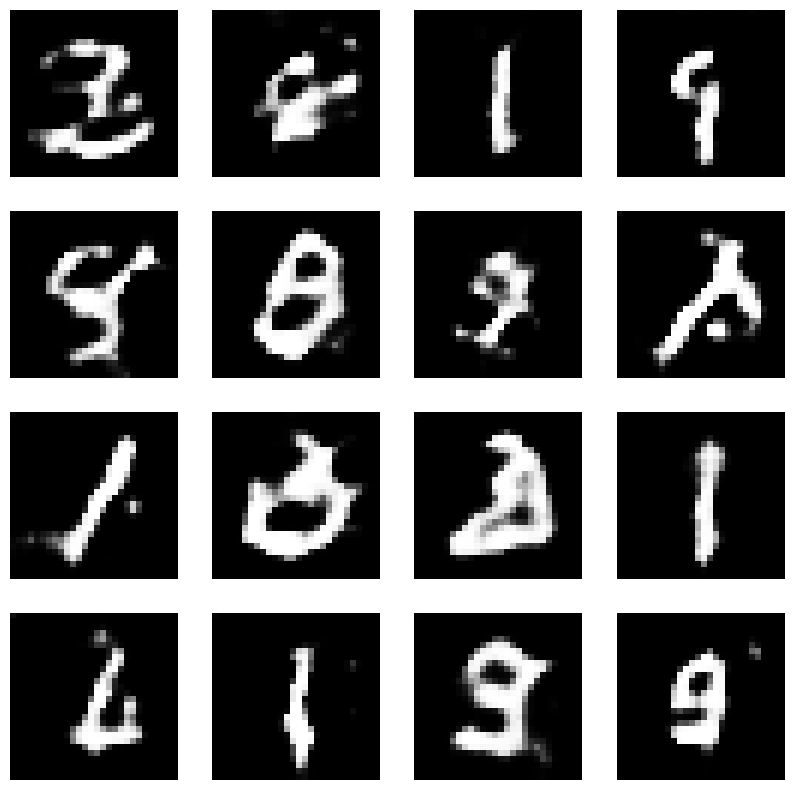

Epoch:  27


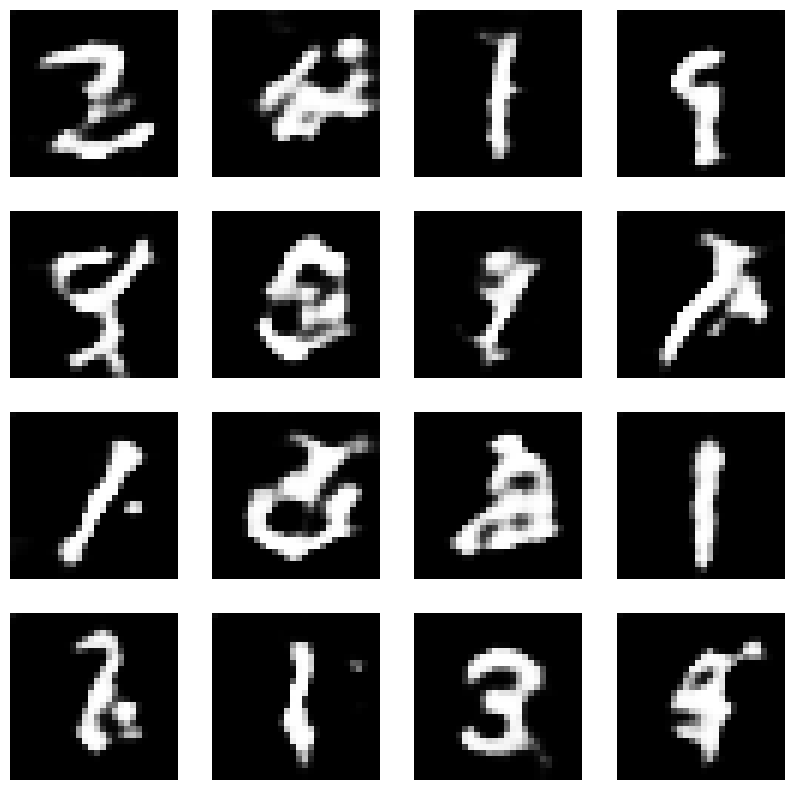

Epoch:  28


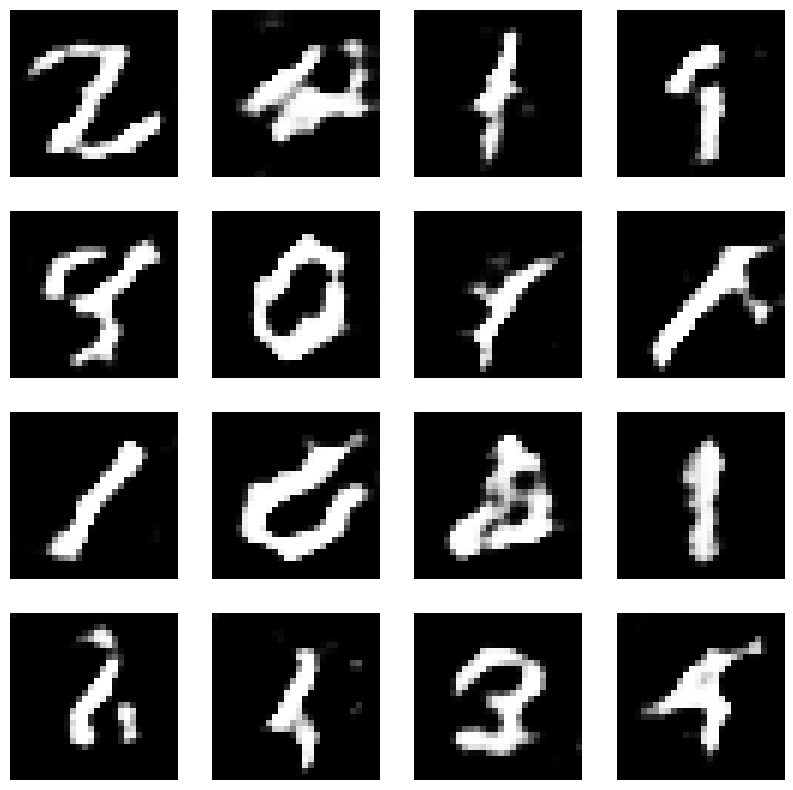

Epoch:  29


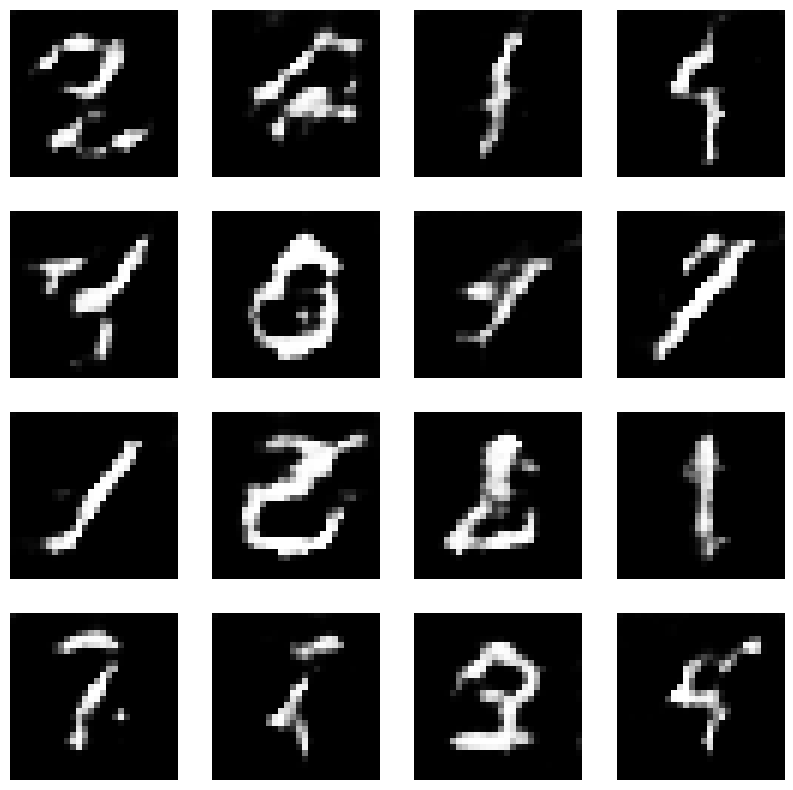

Epoch:  30


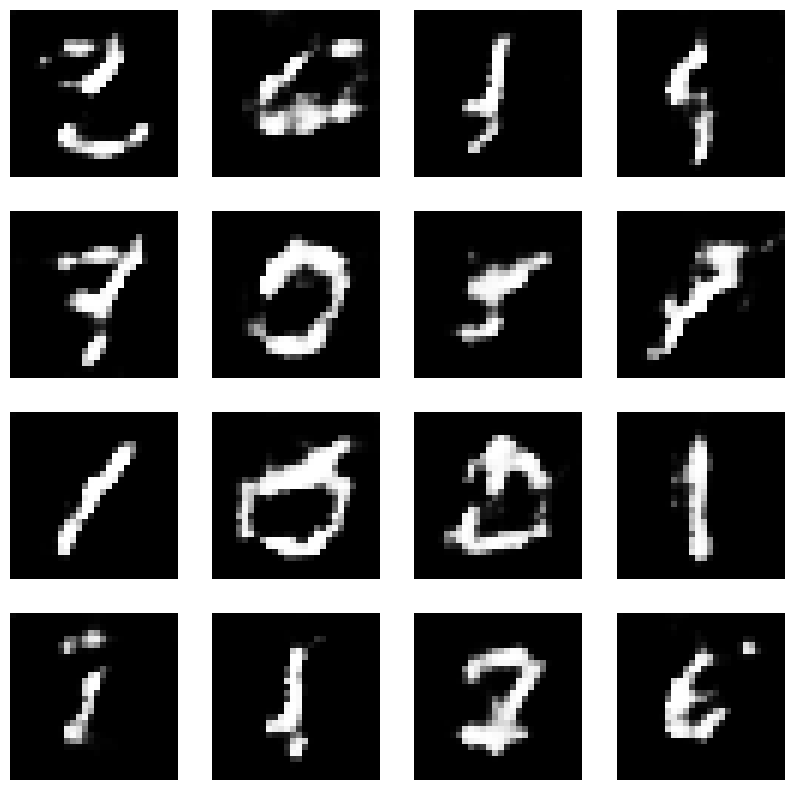

Epoch:  31


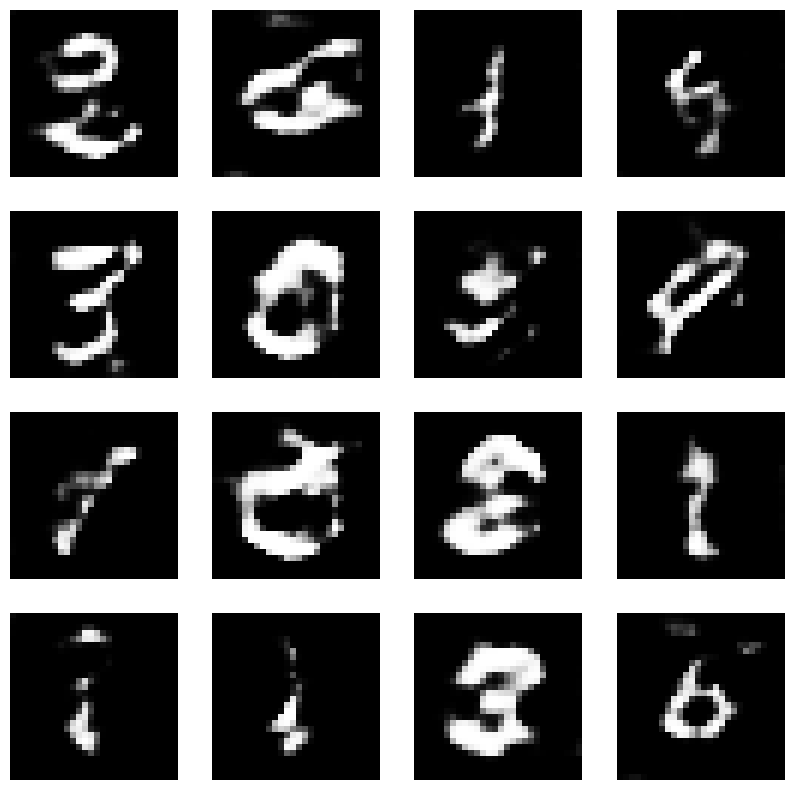

Epoch:  32


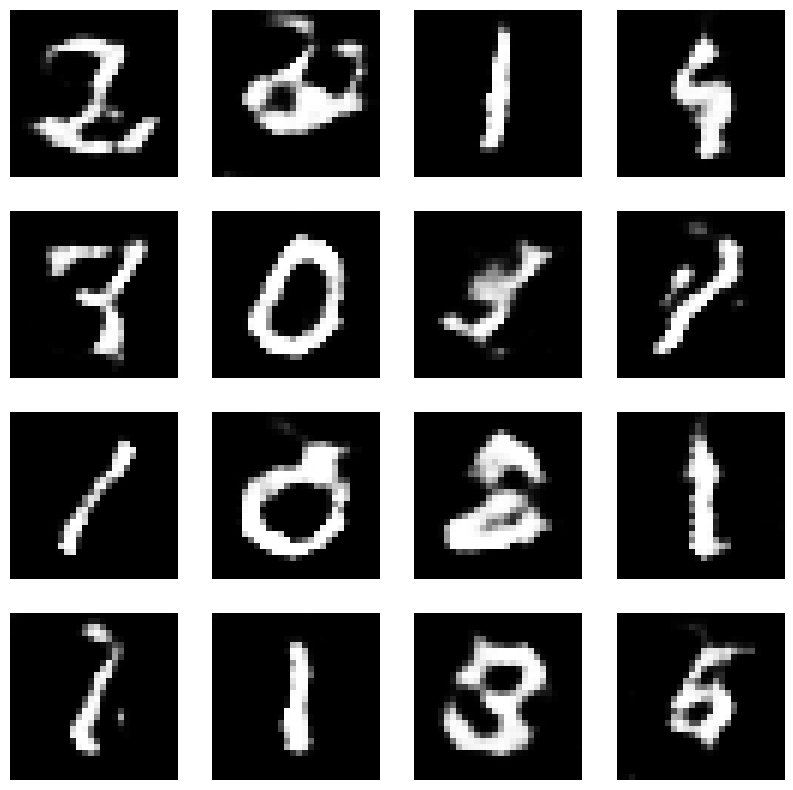

Epoch:  33


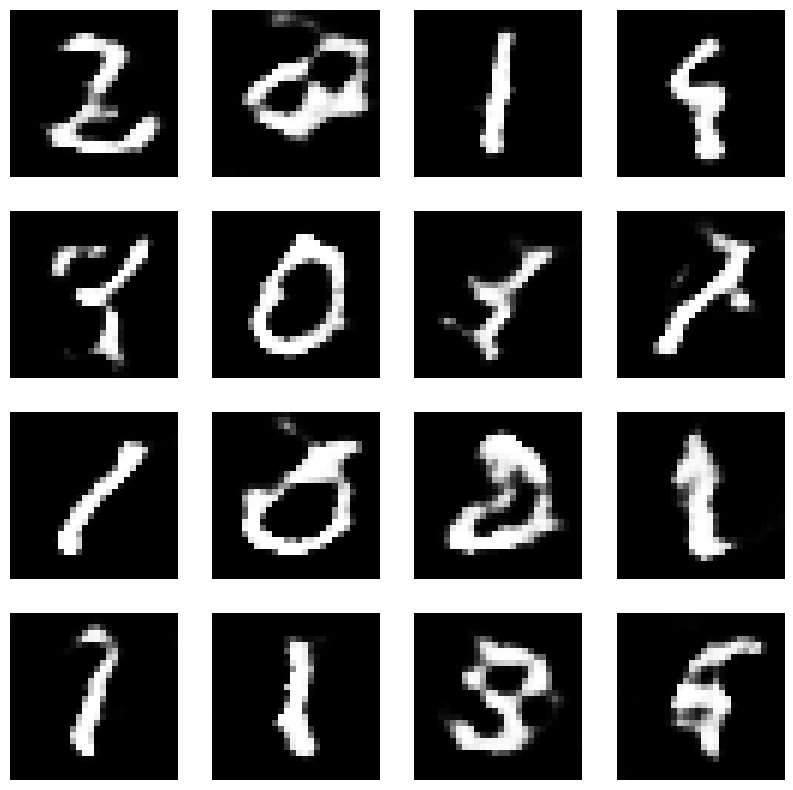

Epoch:  34


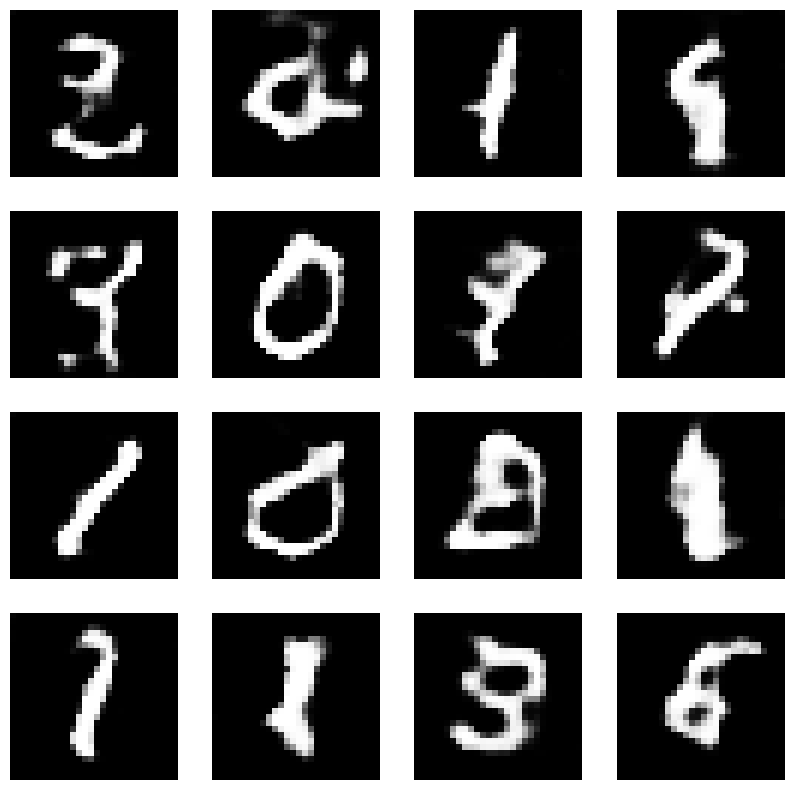

Epoch:  35


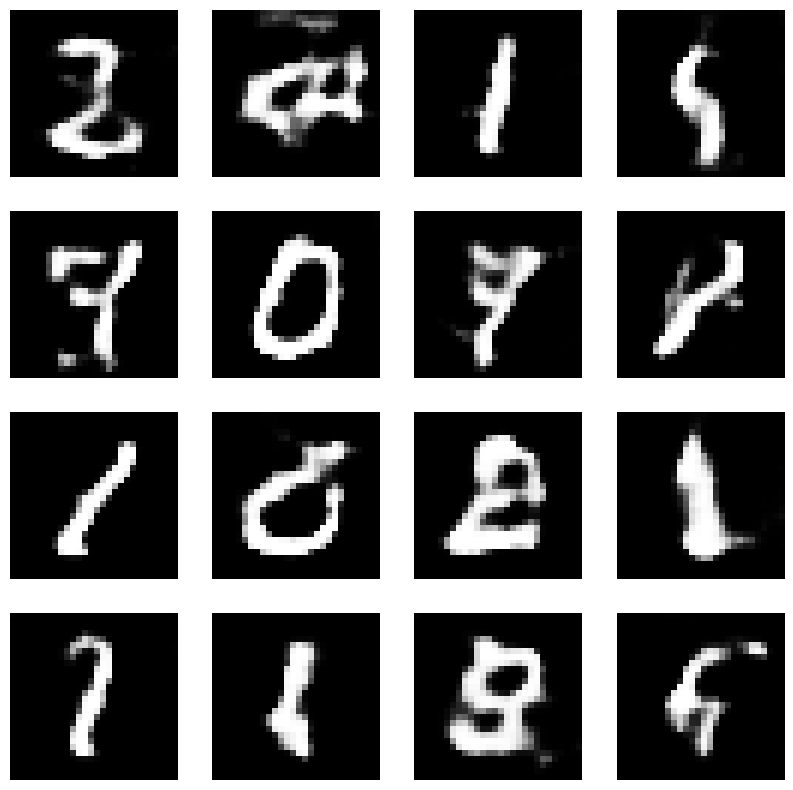

Epoch:  36


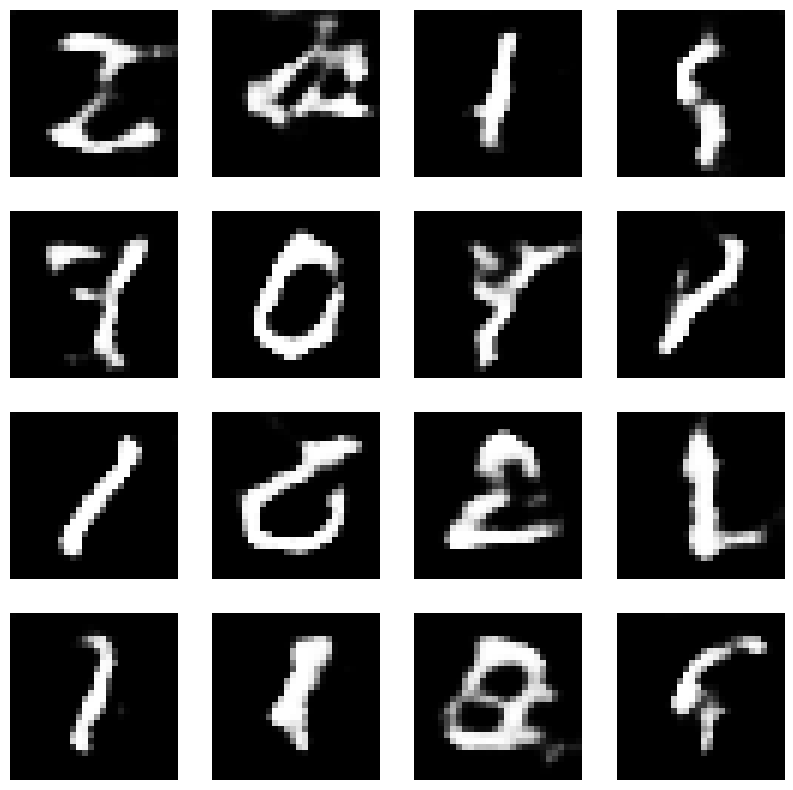

Epoch:  37


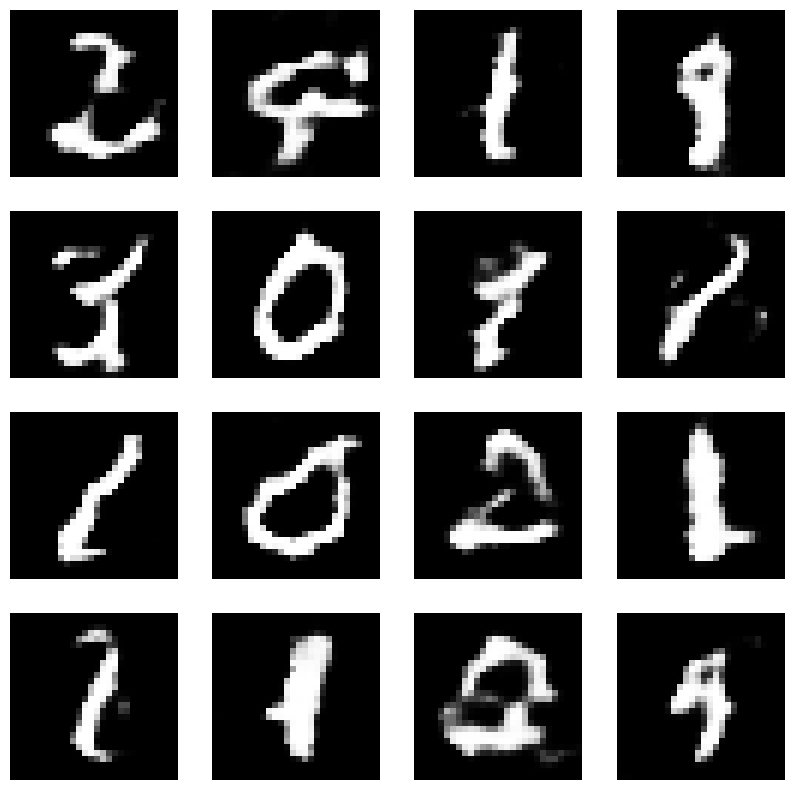

Epoch:  38


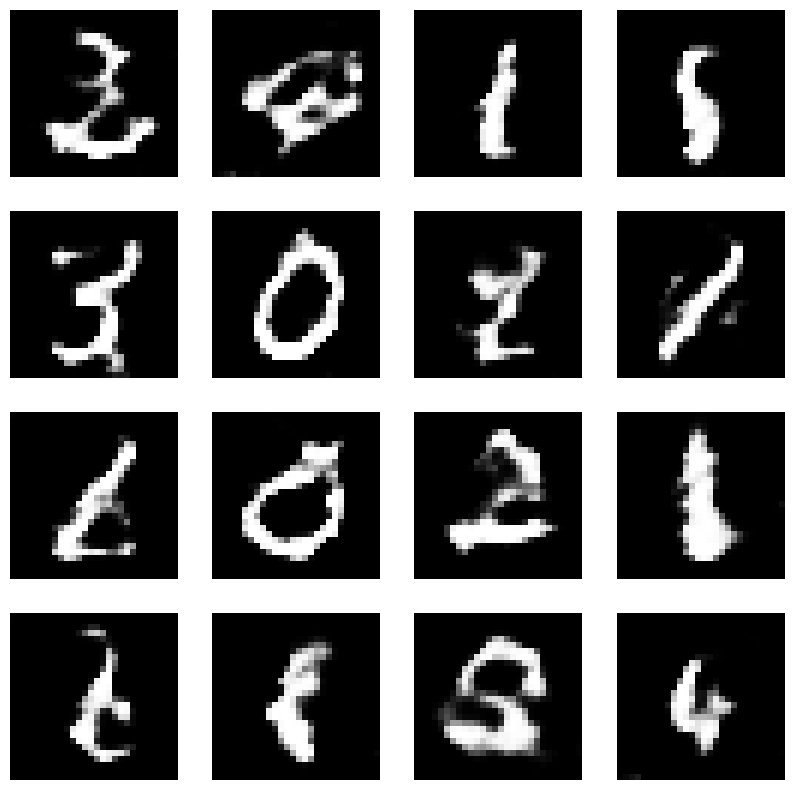

Epoch:  39


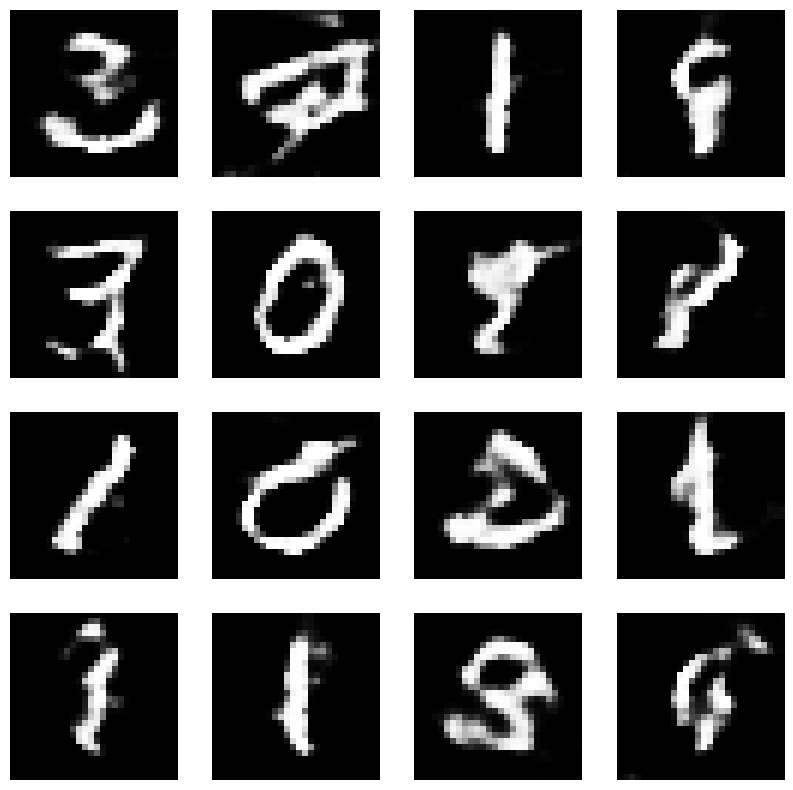

Epoch:  40


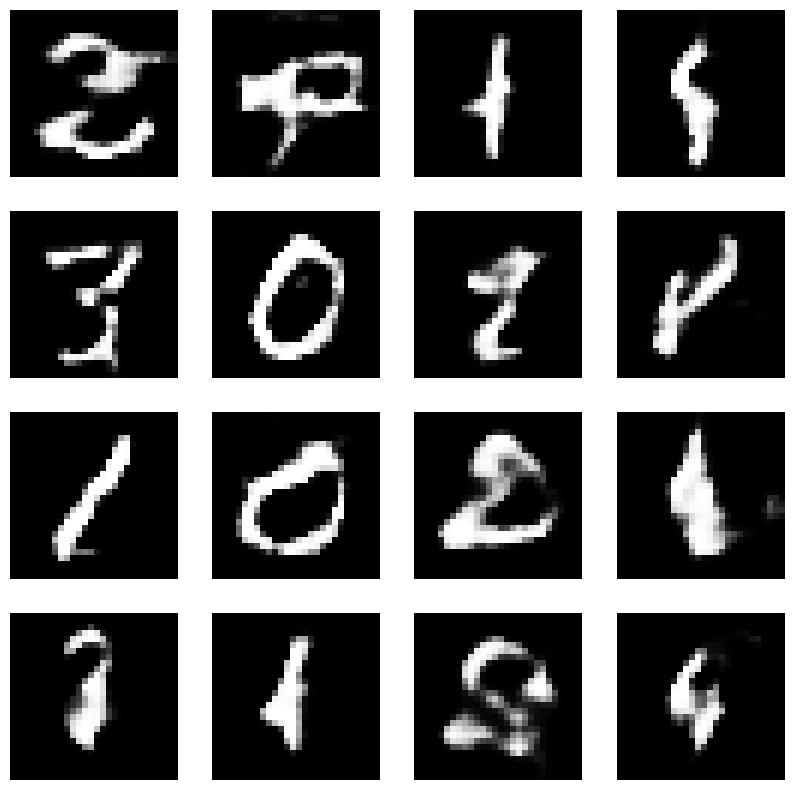

Epoch:  41


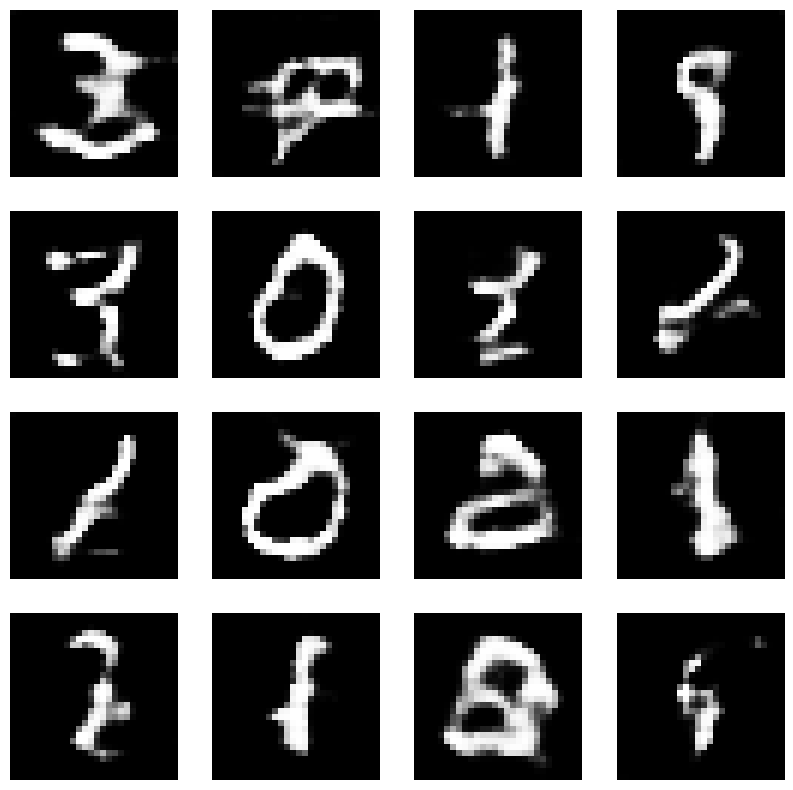

Epoch:  42


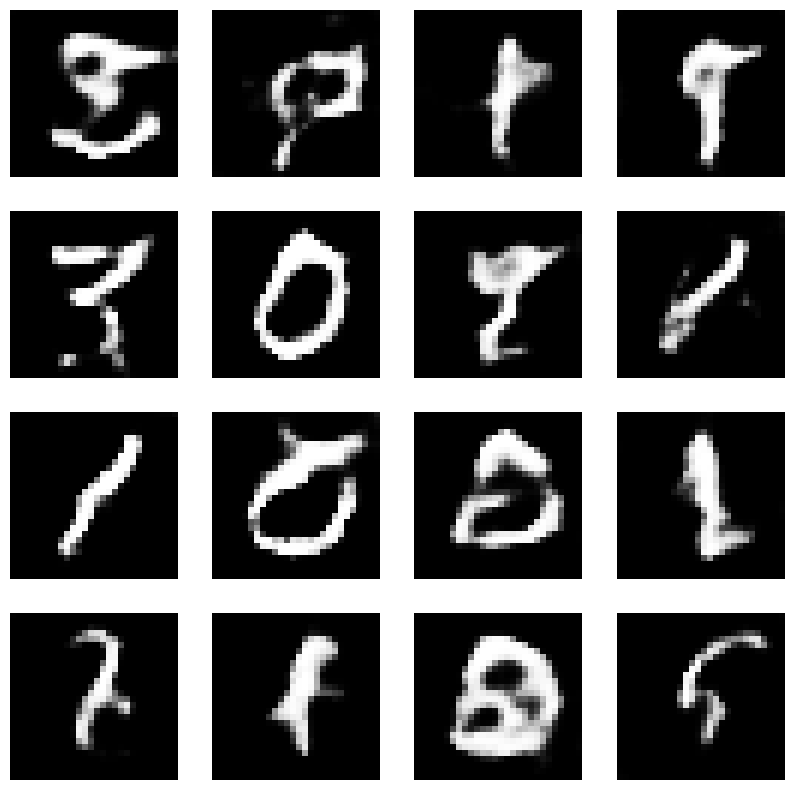

Epoch:  43


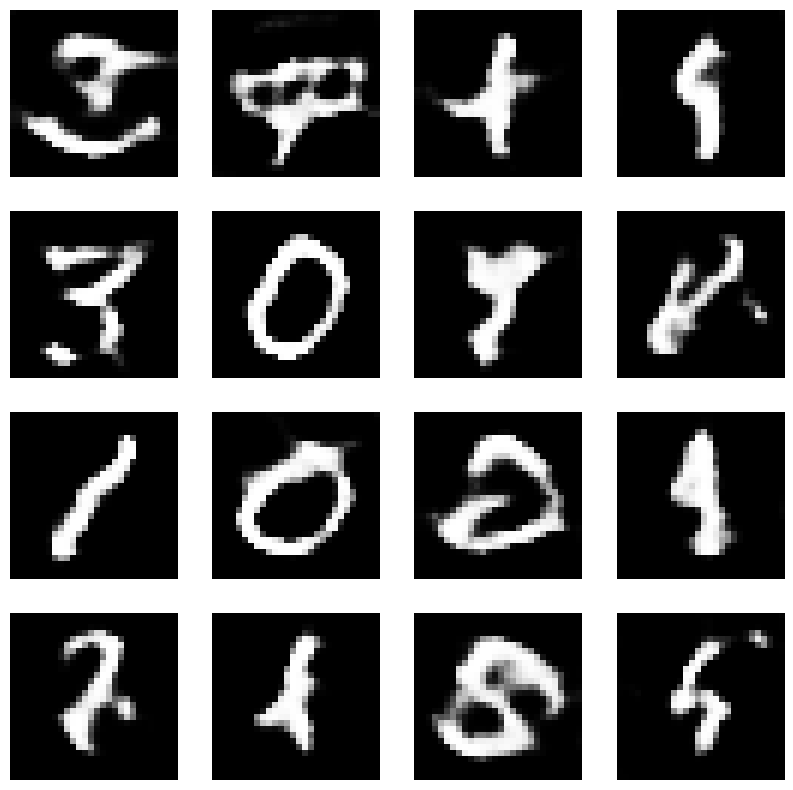

Epoch:  44


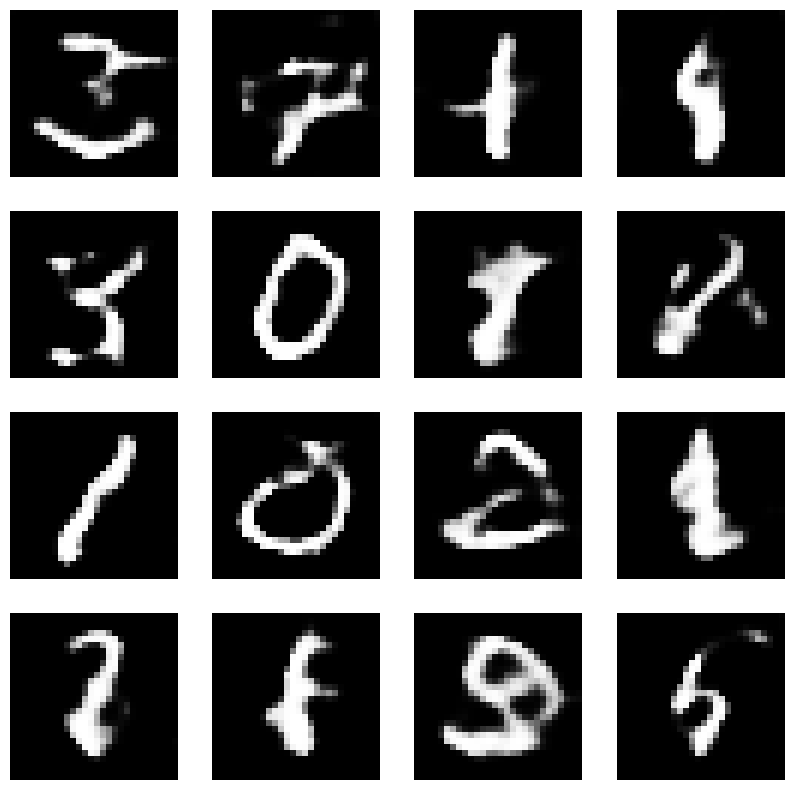

Epoch:  45


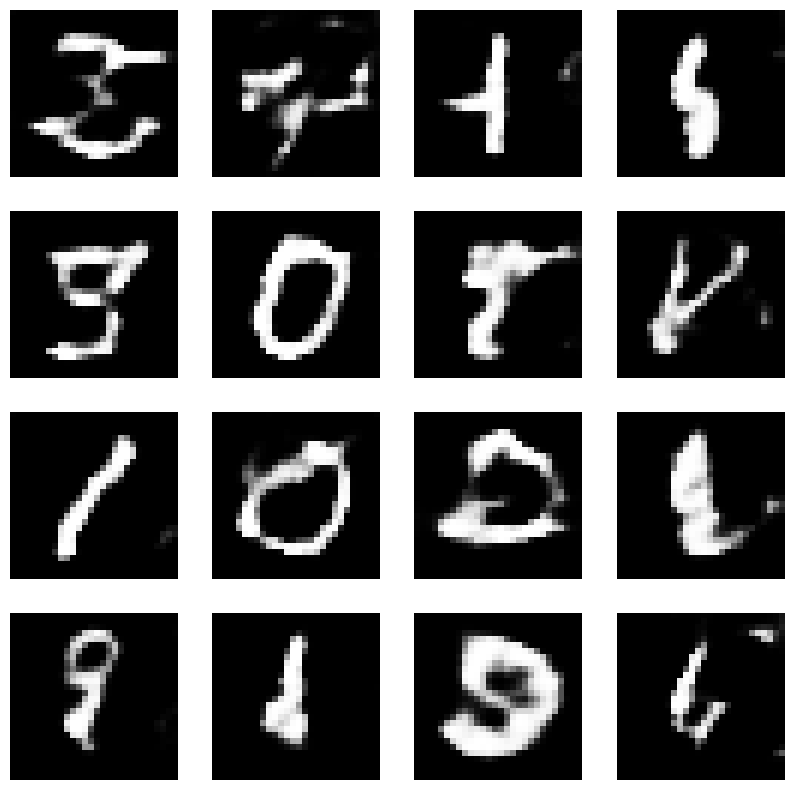

Epoch:  46


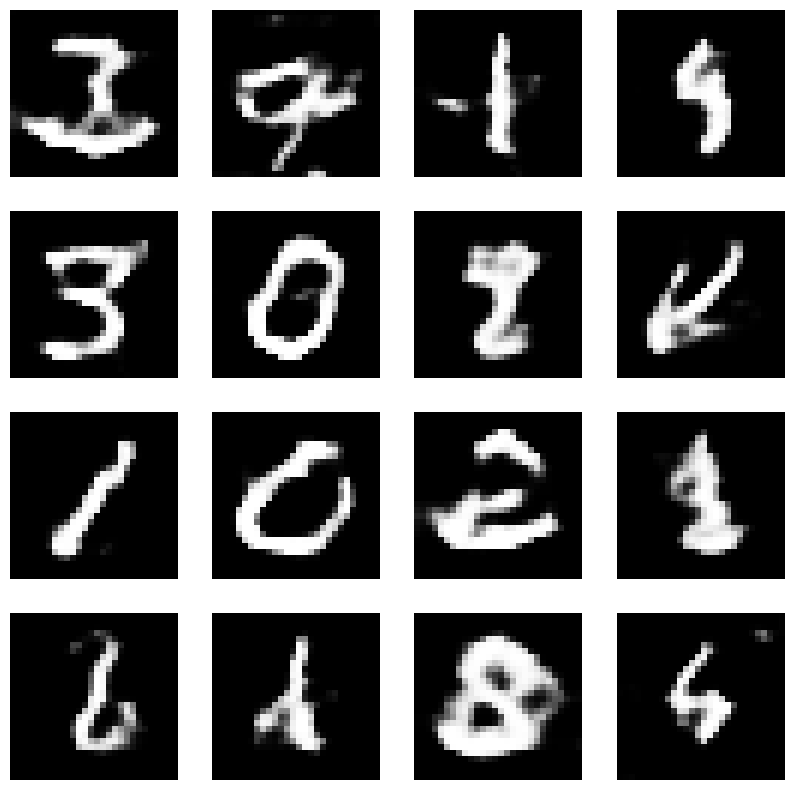

Epoch:  47


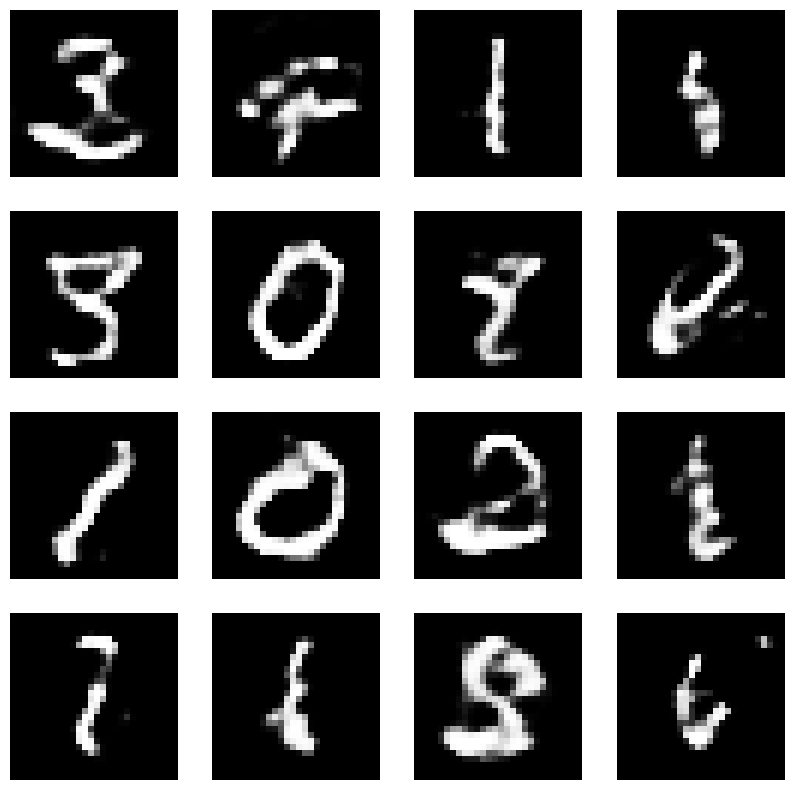

Epoch:  48


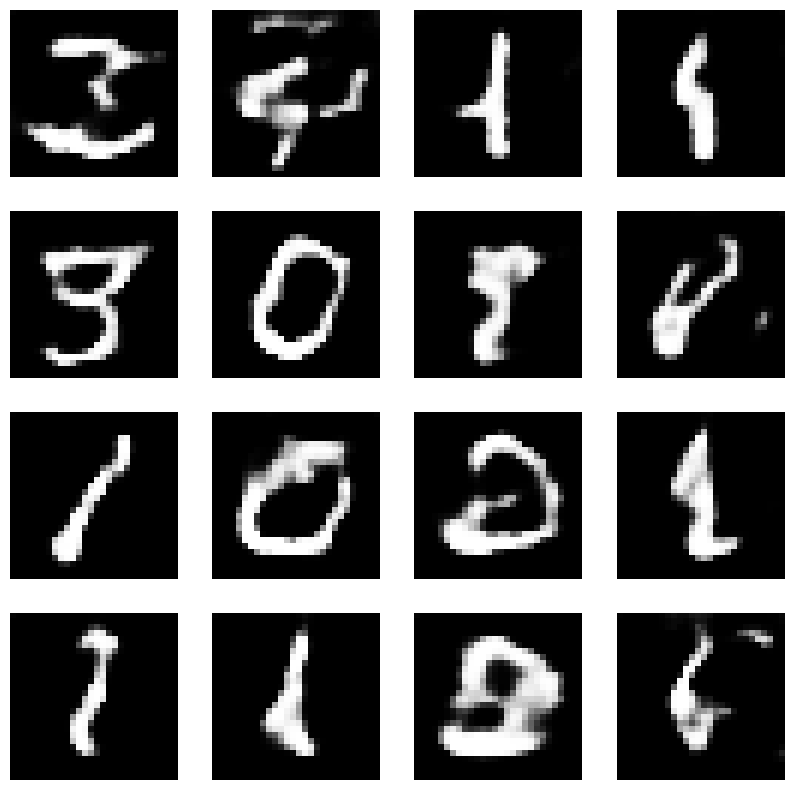

Epoch:  49


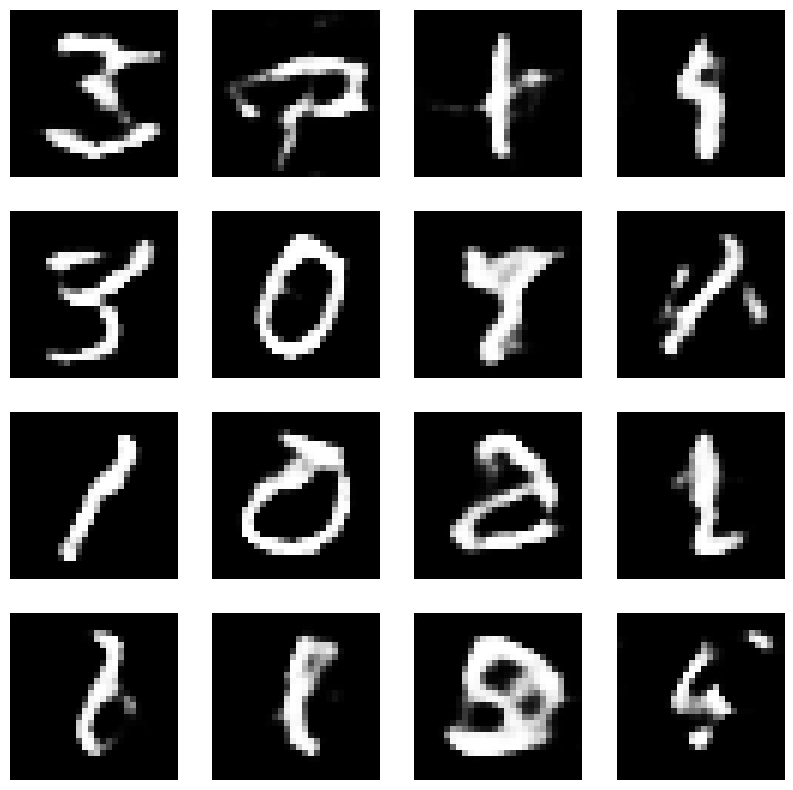

Epoch:  50


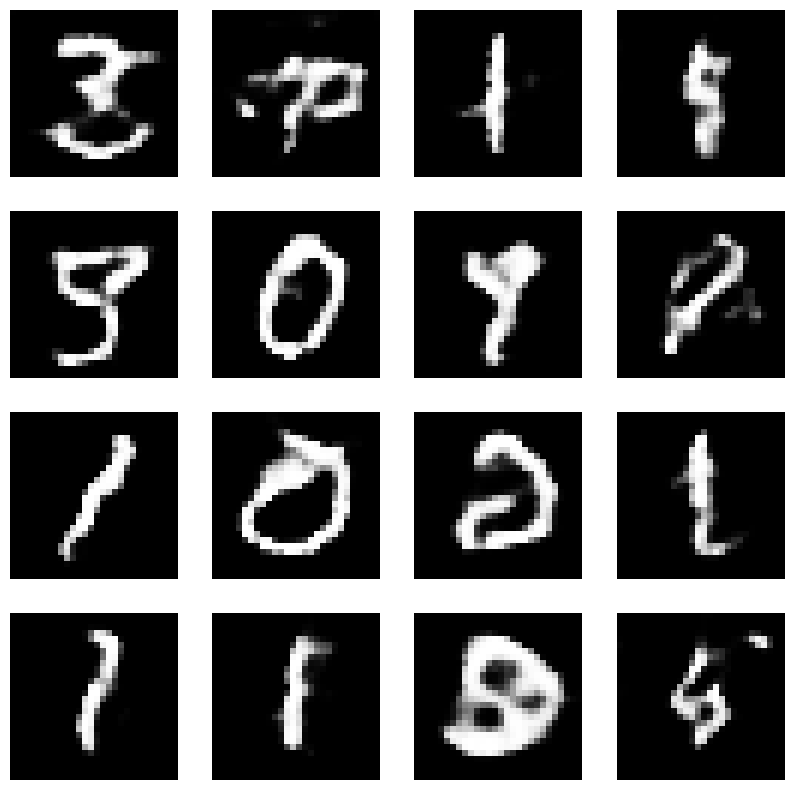

Epoch:  51


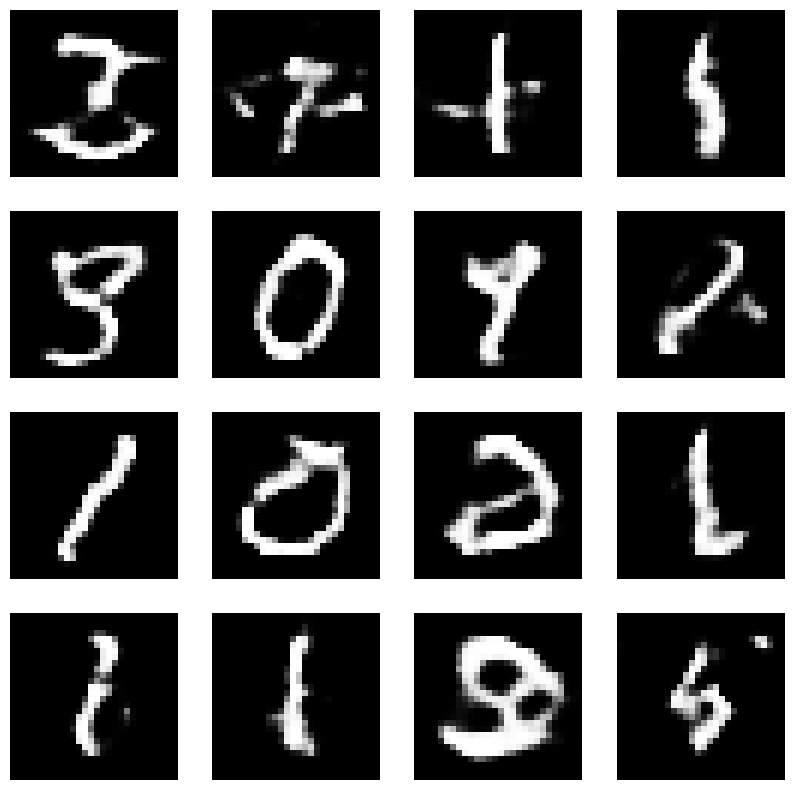

Epoch:  52


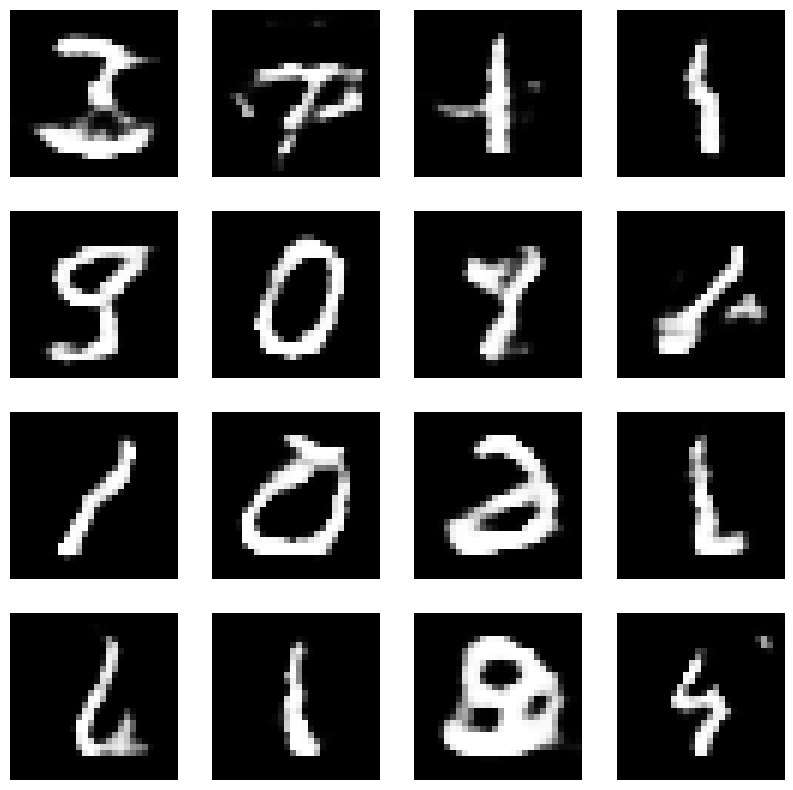

Epoch:  53


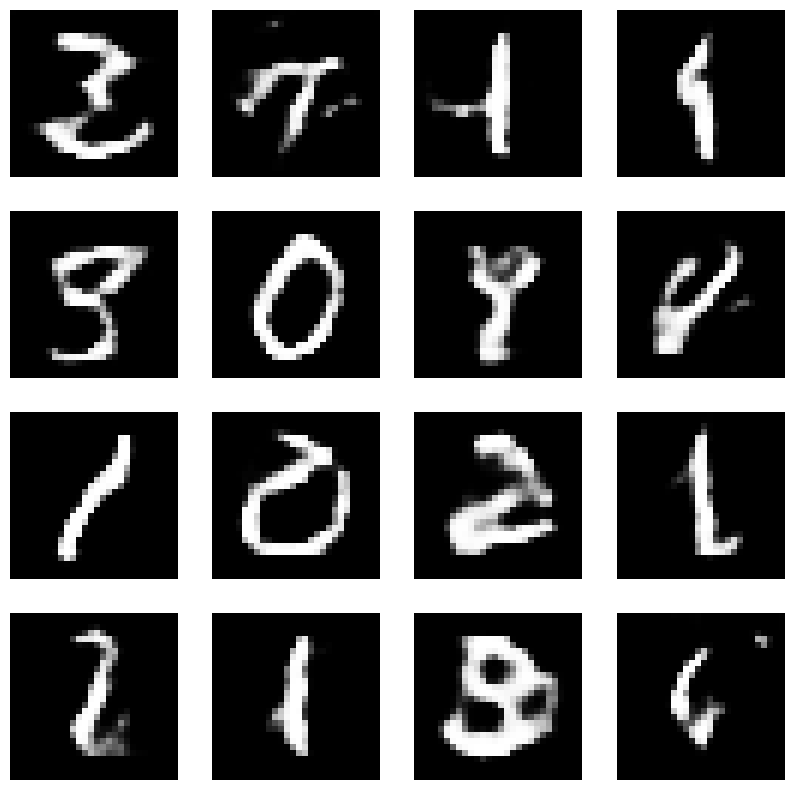

Epoch:  54


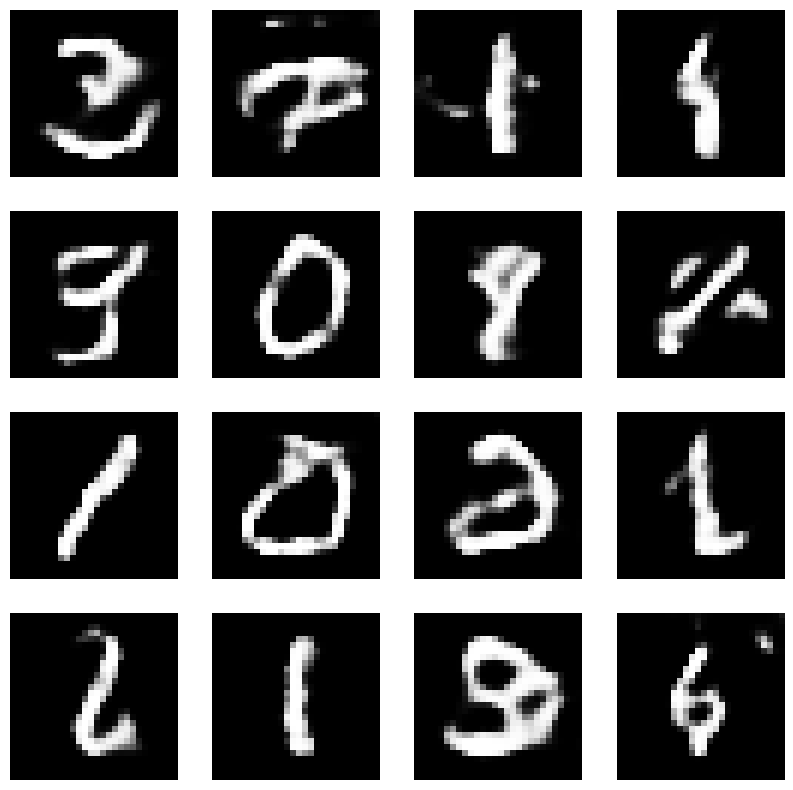

Epoch:  55


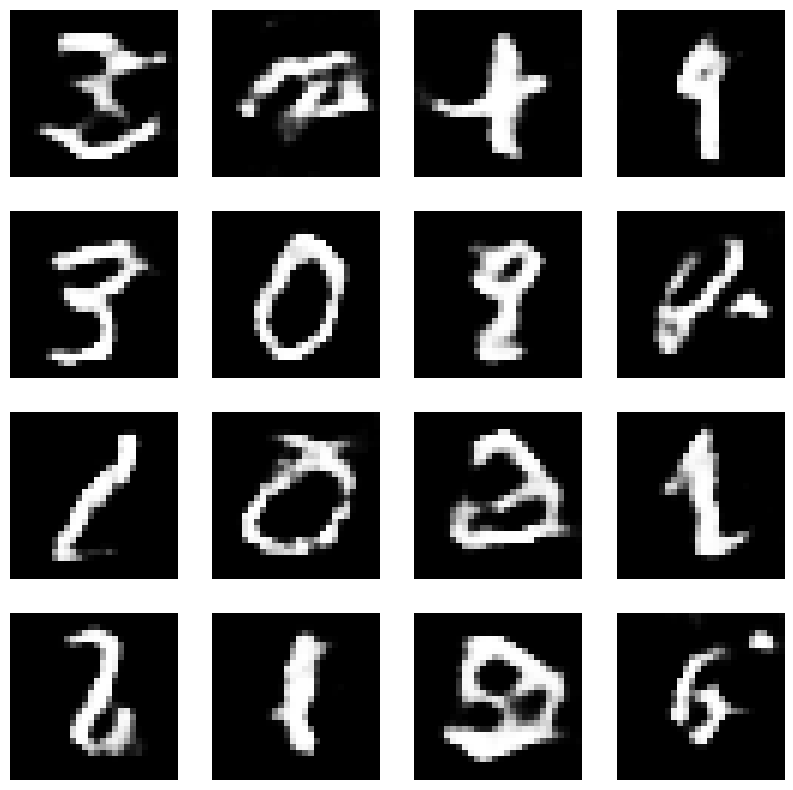

Epoch:  56


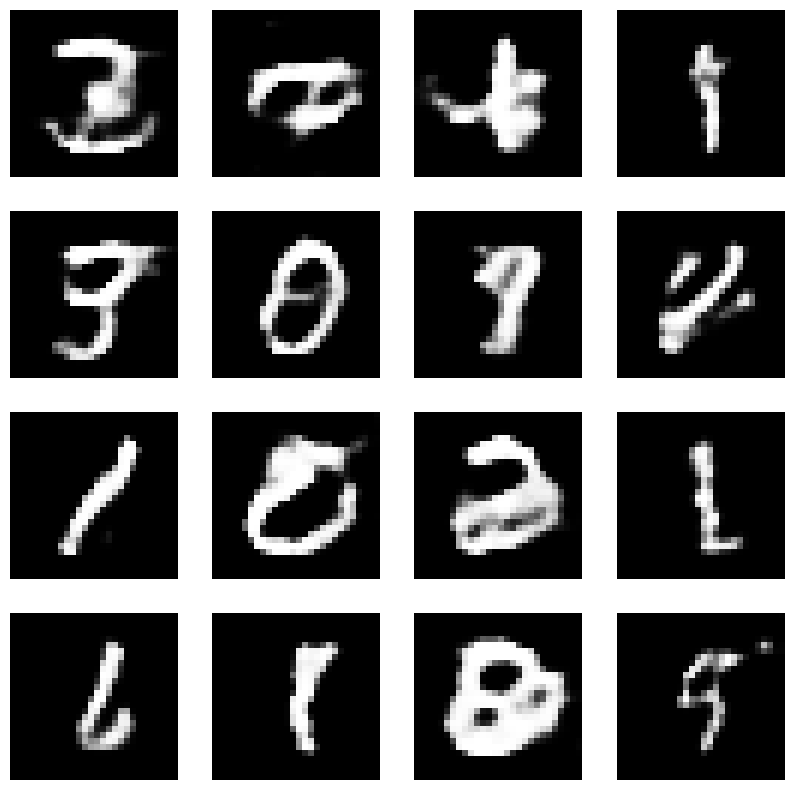

Epoch:  57


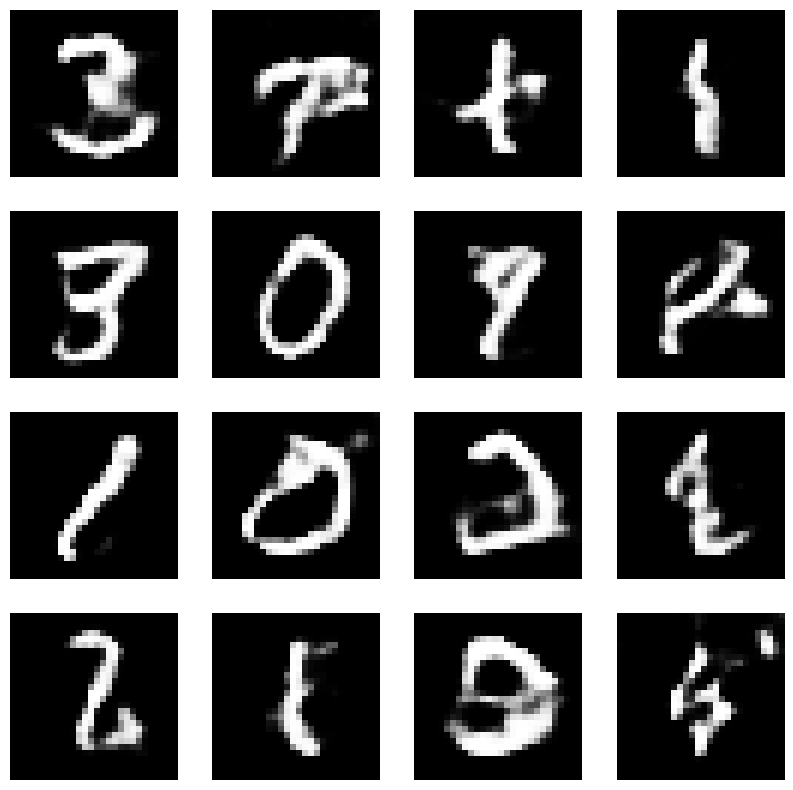

Epoch:  58


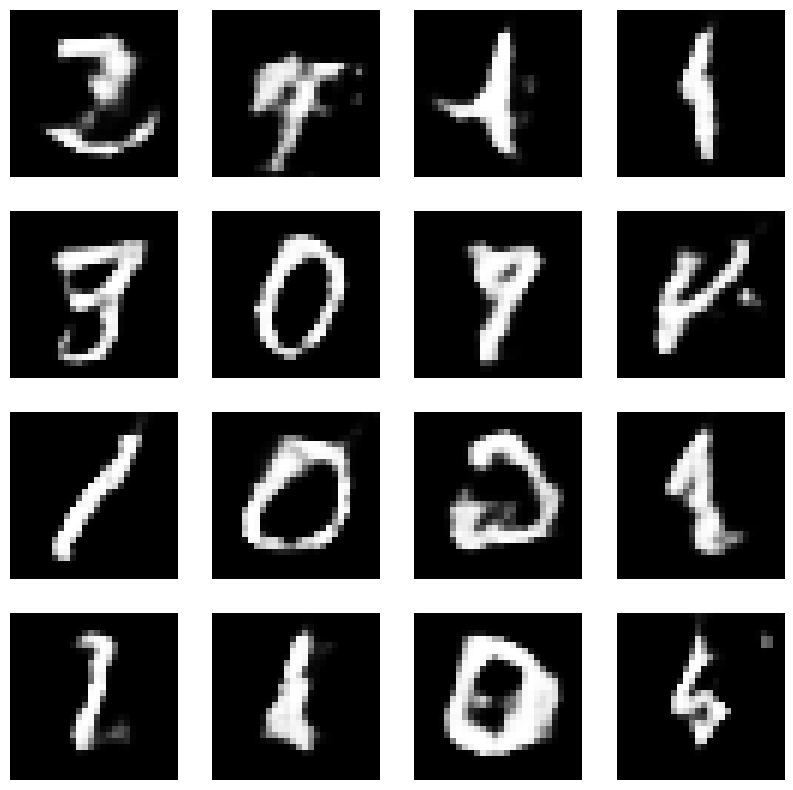

Epoch:  59


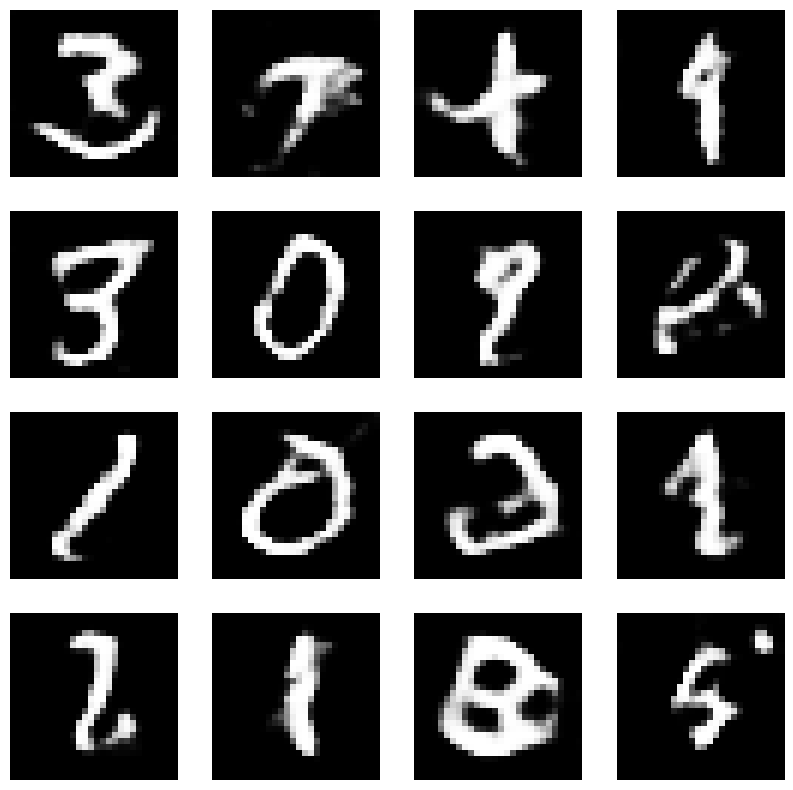

Epoch:  60


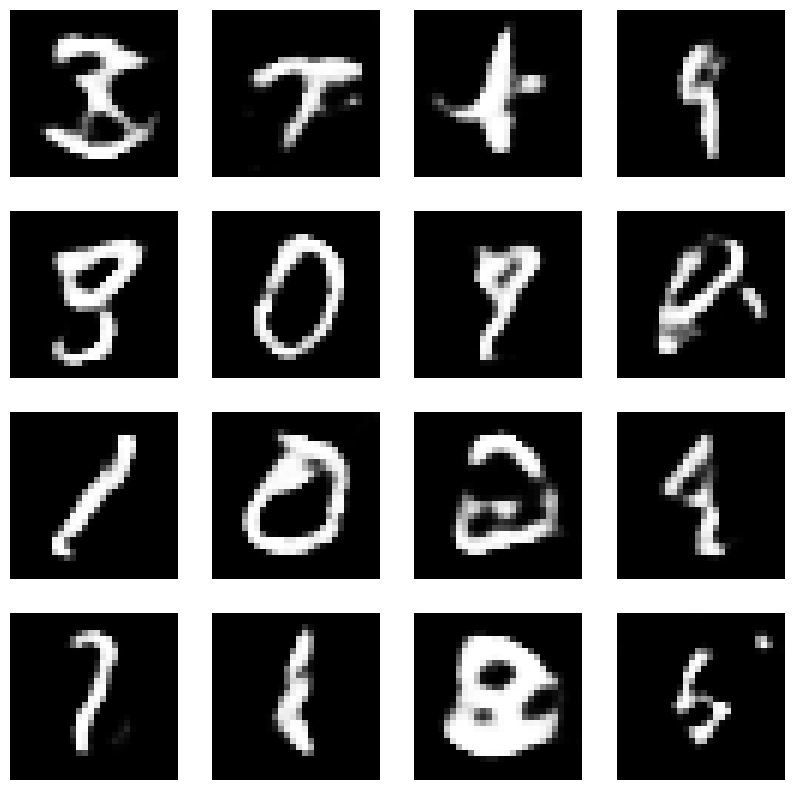

Epoch:  61


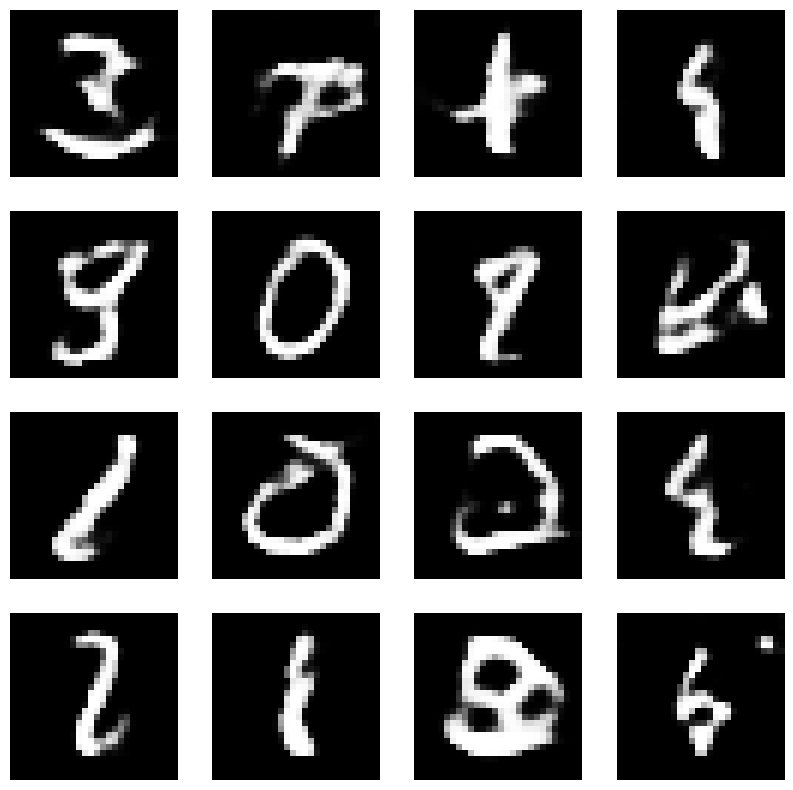

Epoch:  62


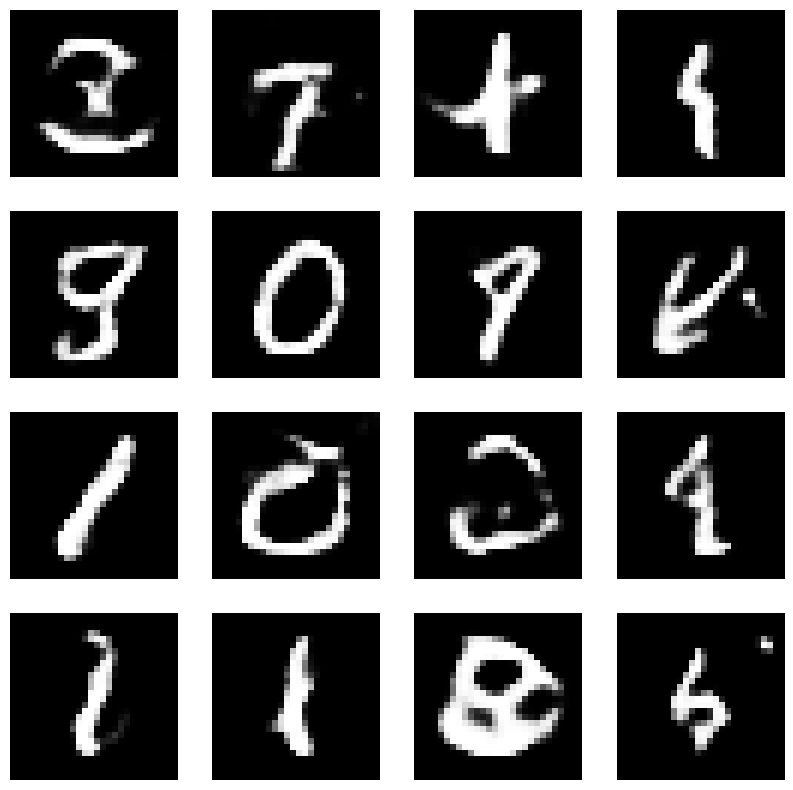

Epoch:  63


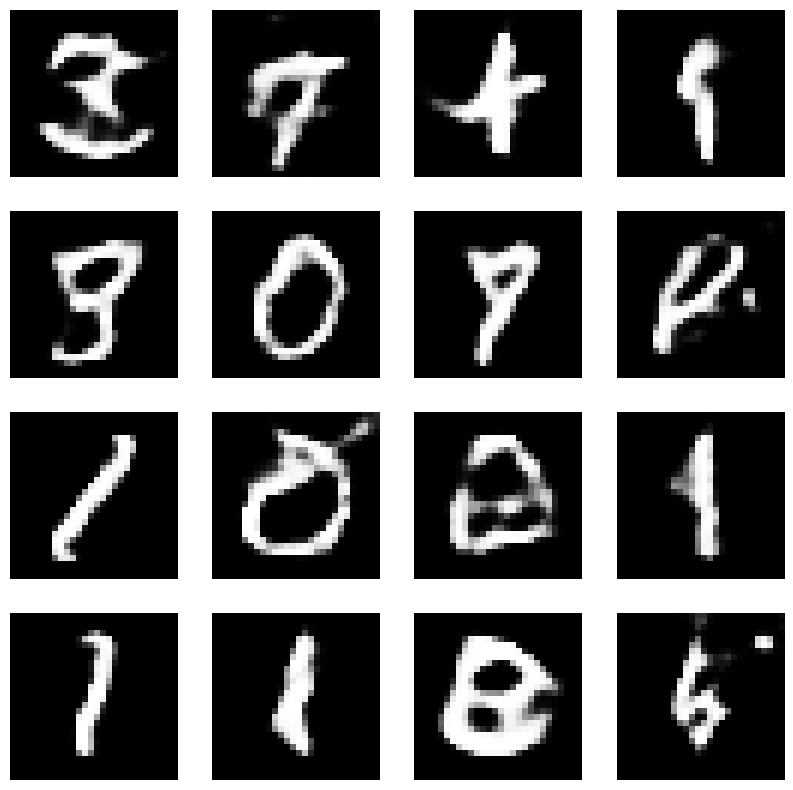

Epoch:  64


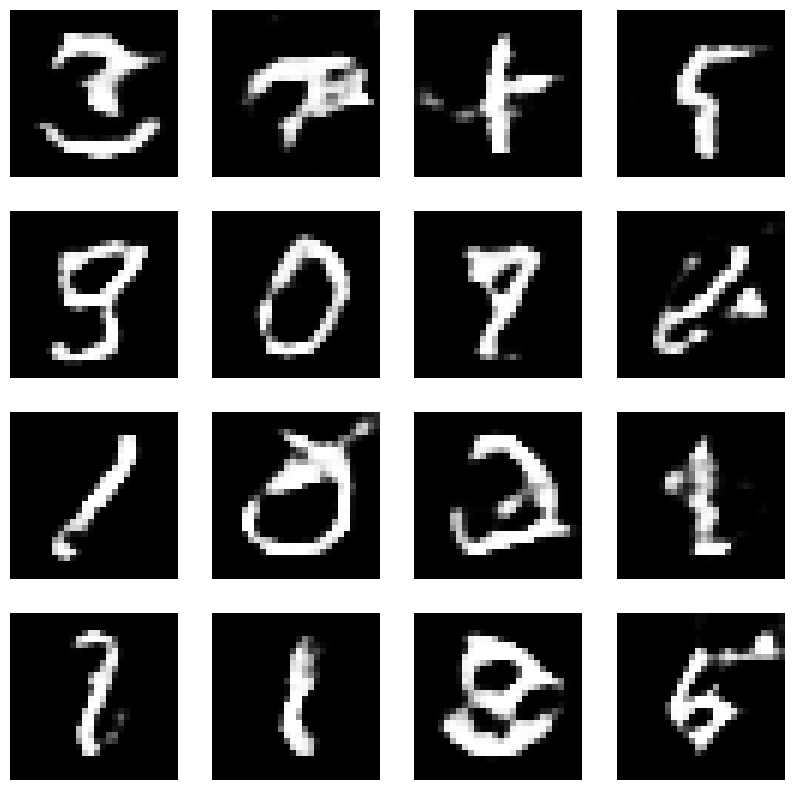

Epoch:  65


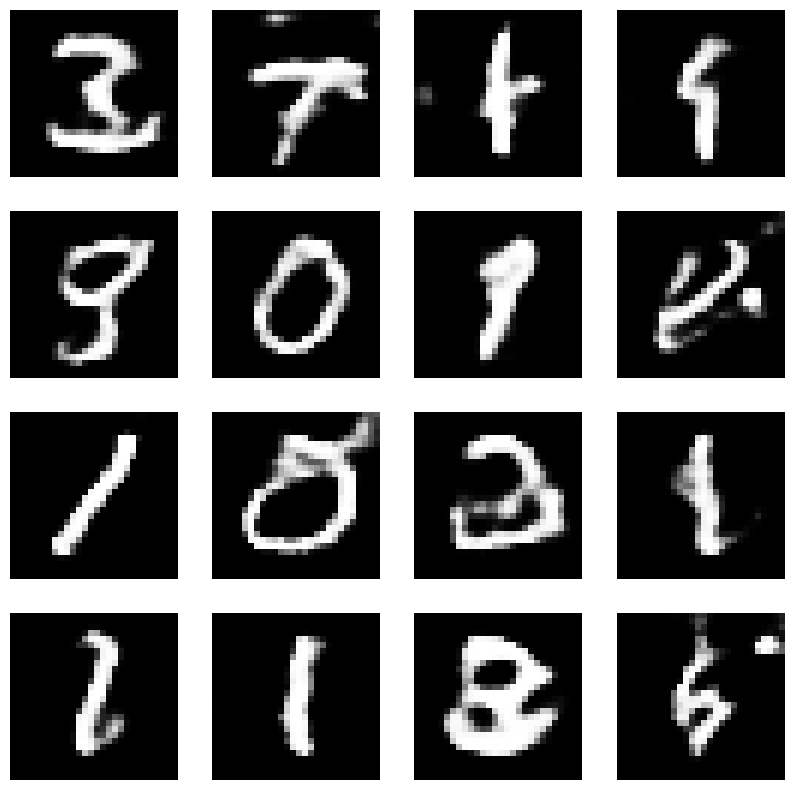

Epoch:  66


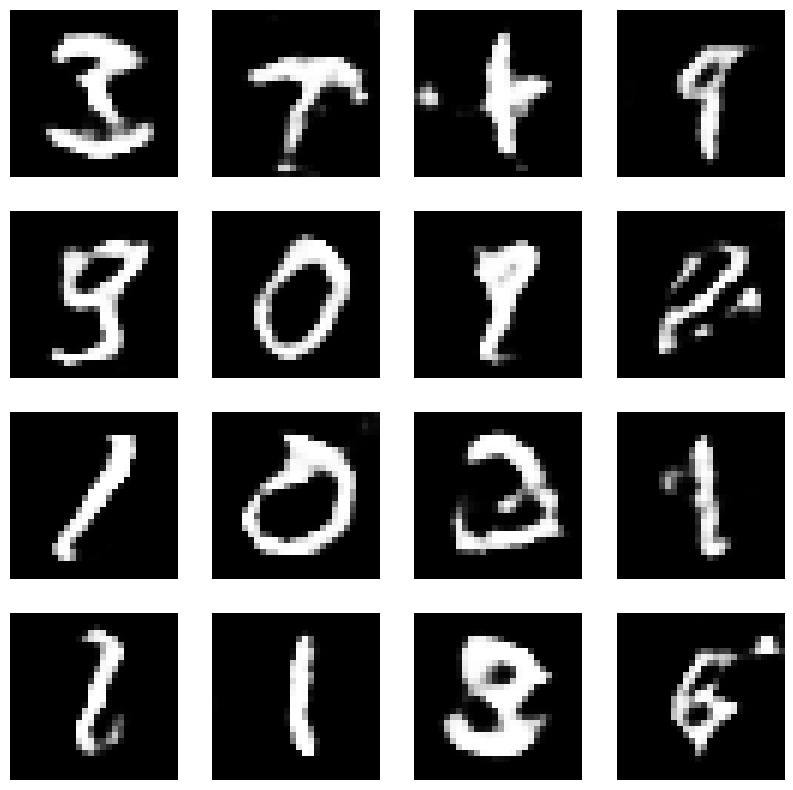

Epoch:  67


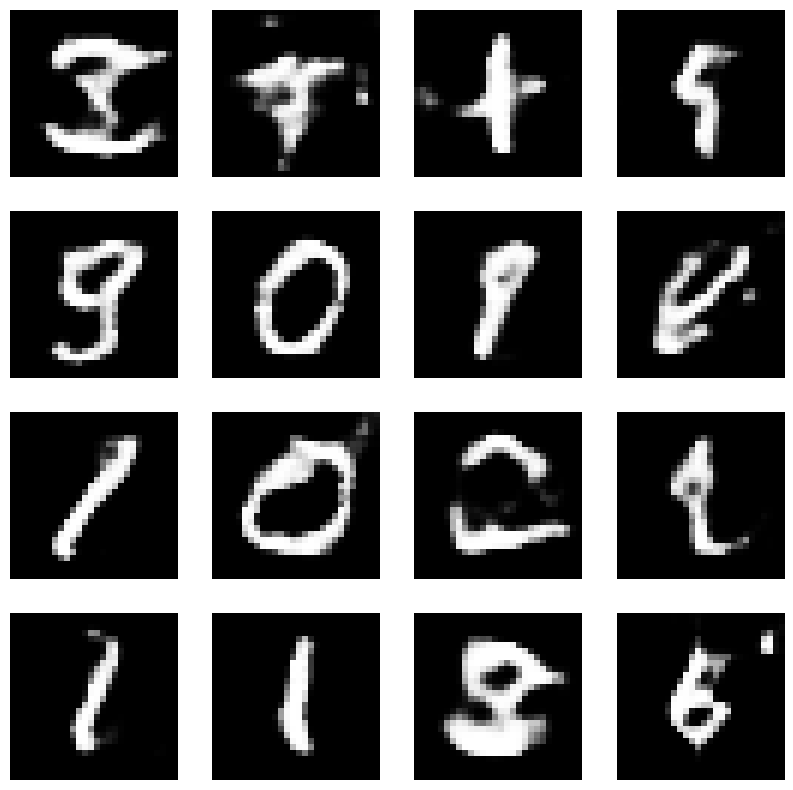

Epoch:  68


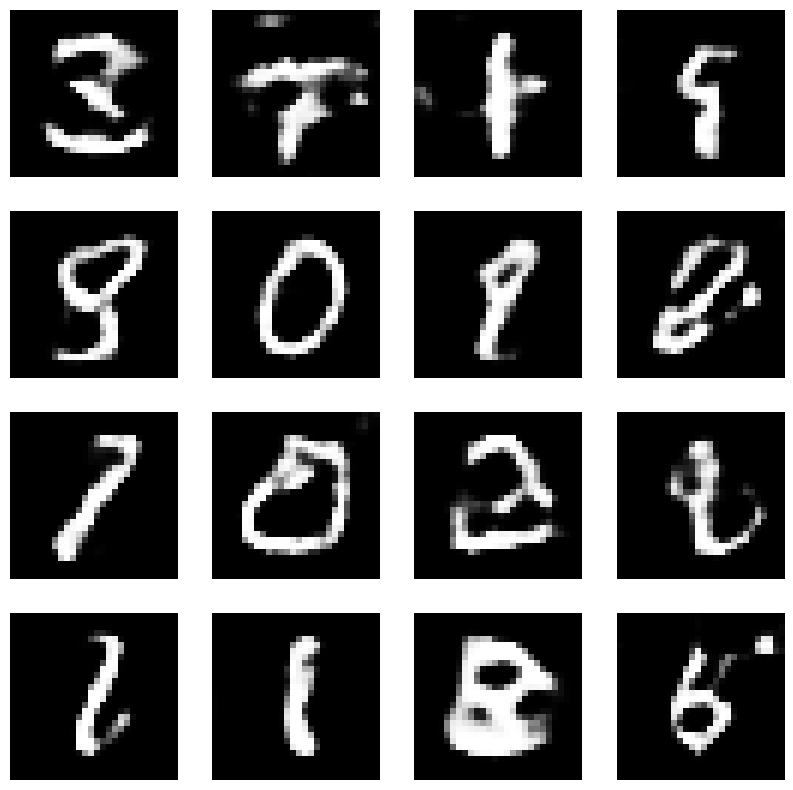

Epoch:  69


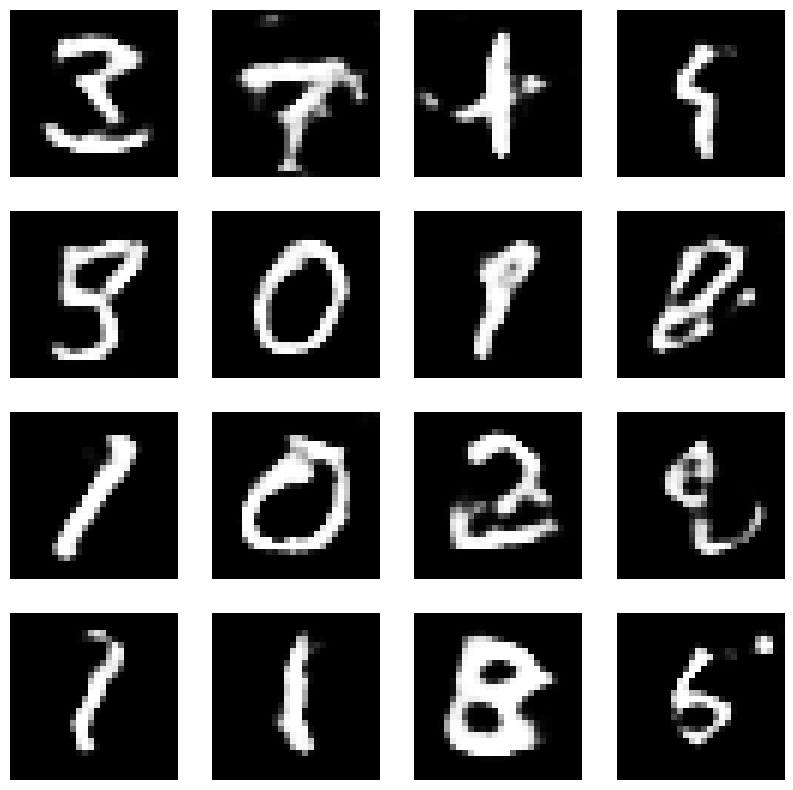

Epoch:  70


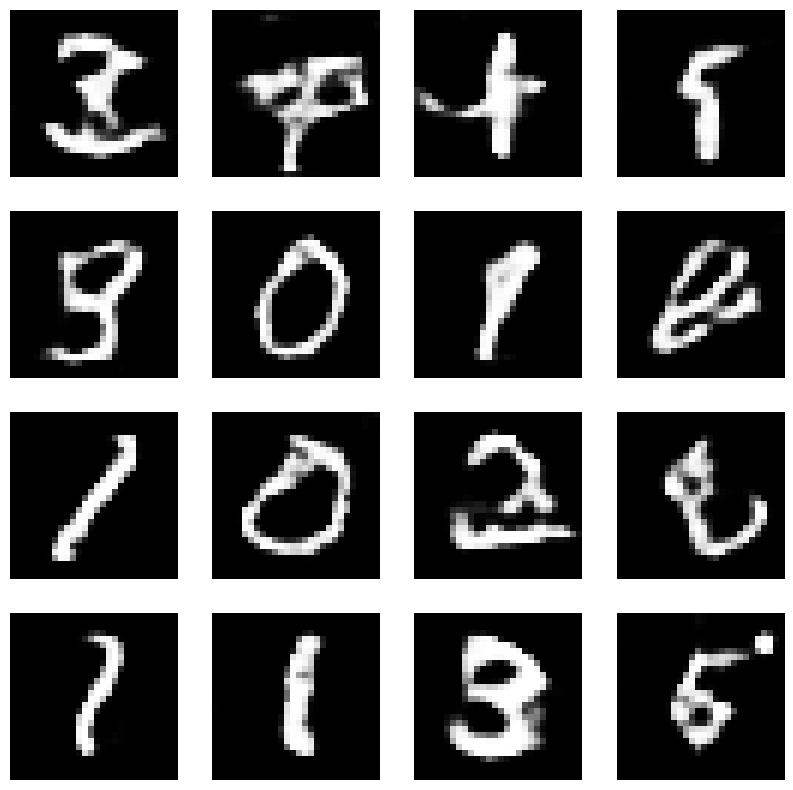

Epoch:  71


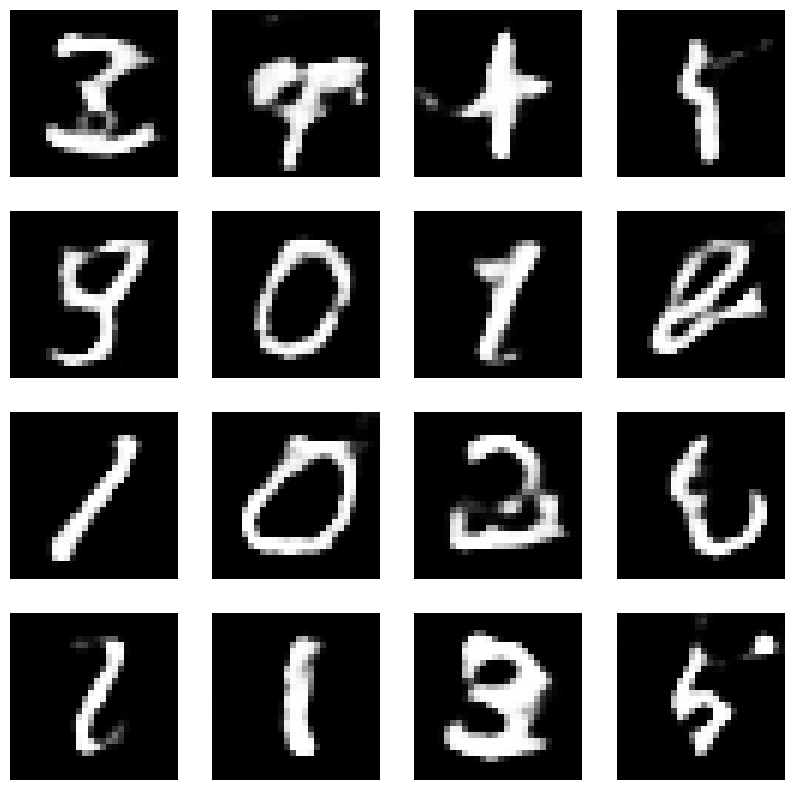

Epoch:  72


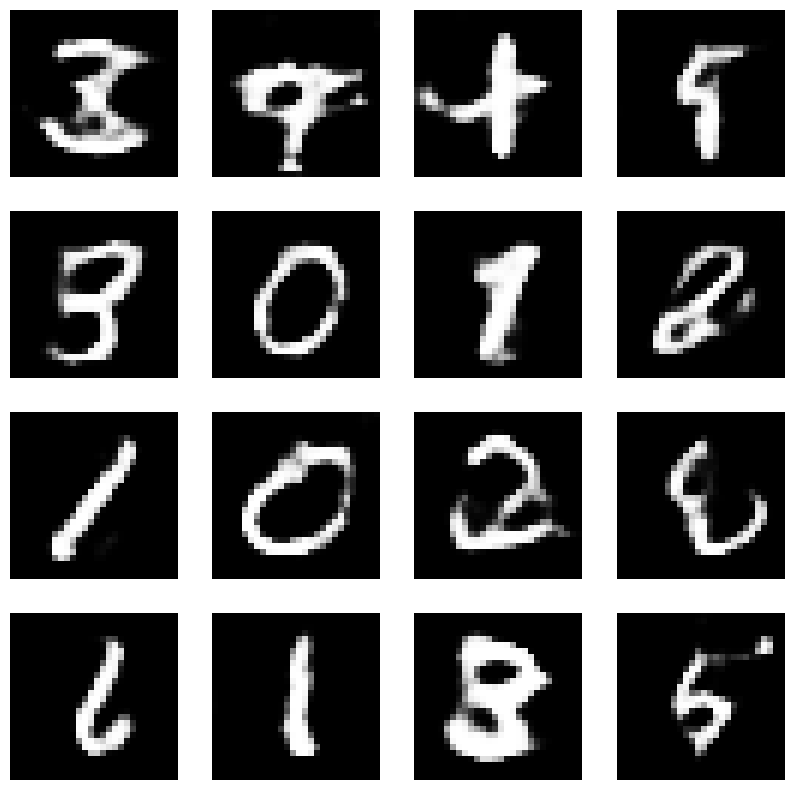

Epoch:  73


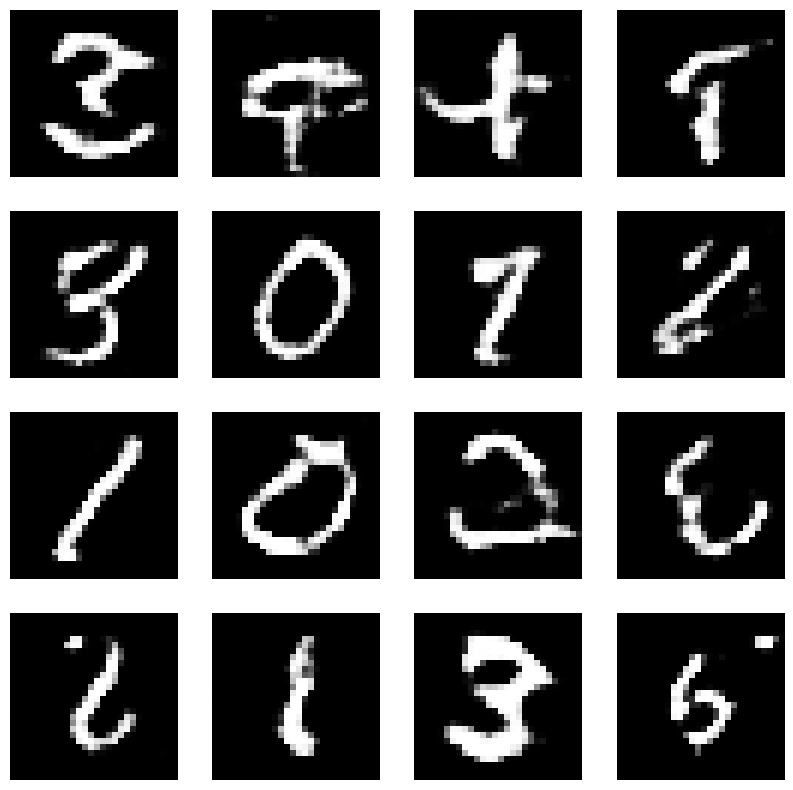

Epoch:  74


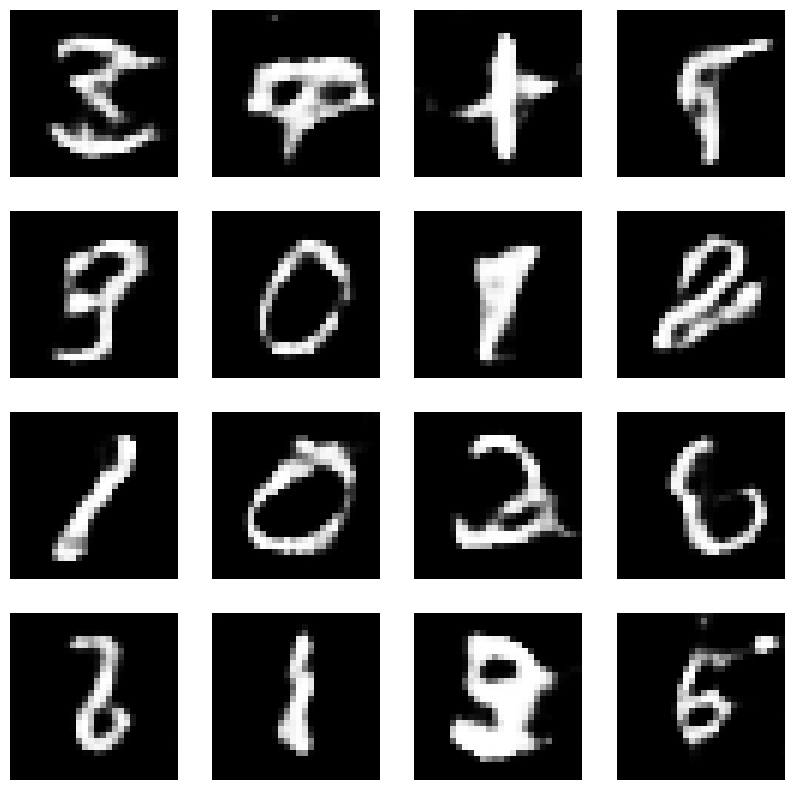

Epoch:  75


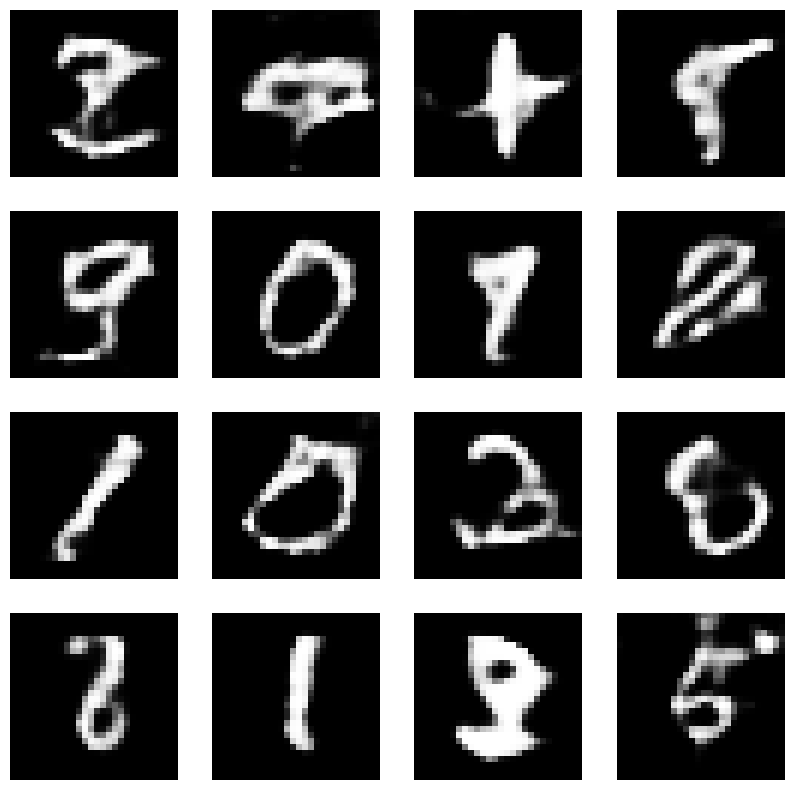

Epoch:  76


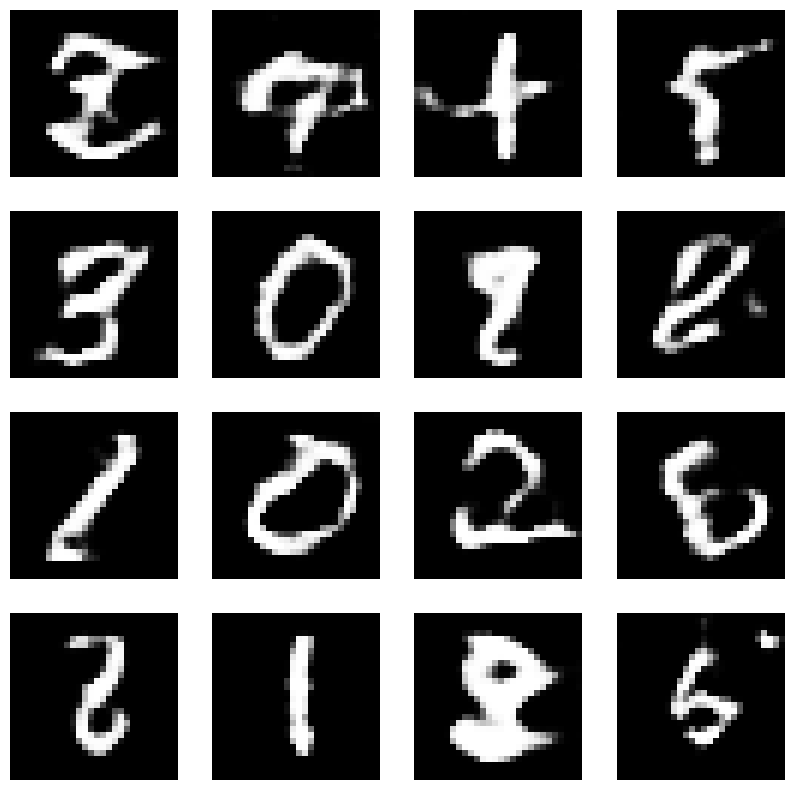

Epoch:  77


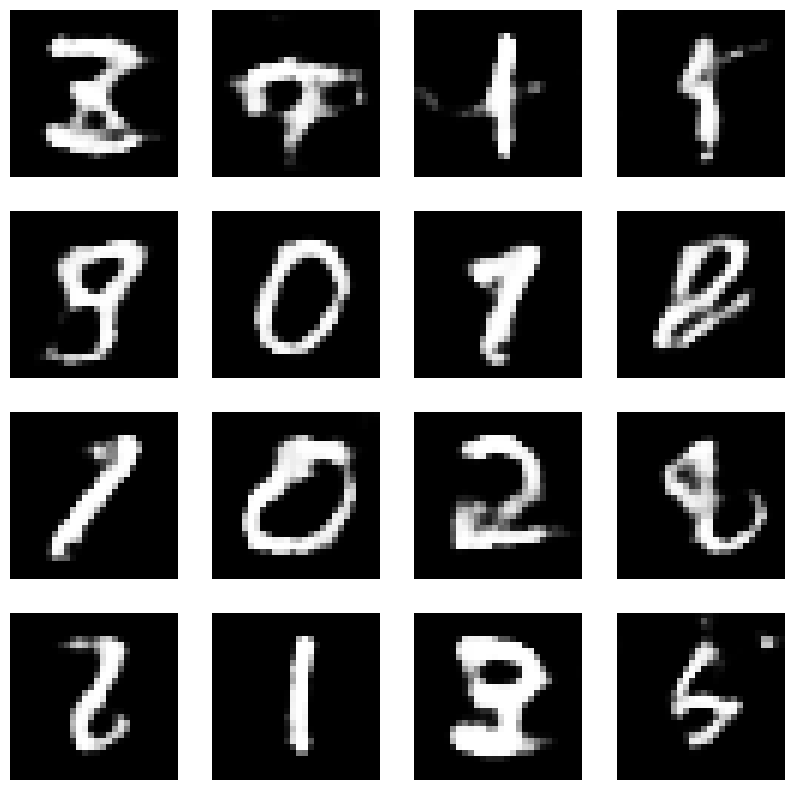

Epoch:  78


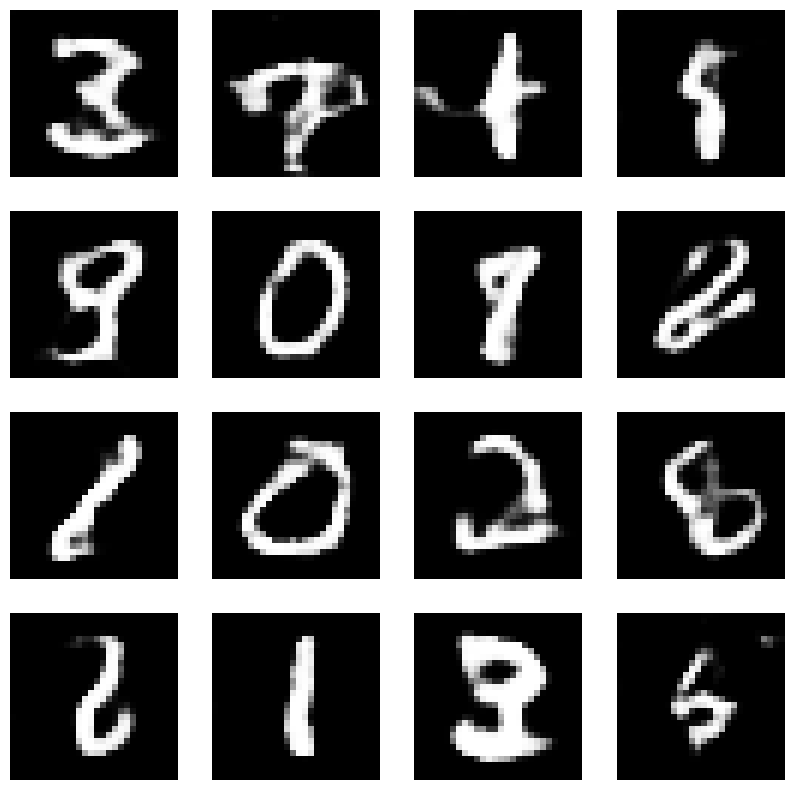

Epoch:  79


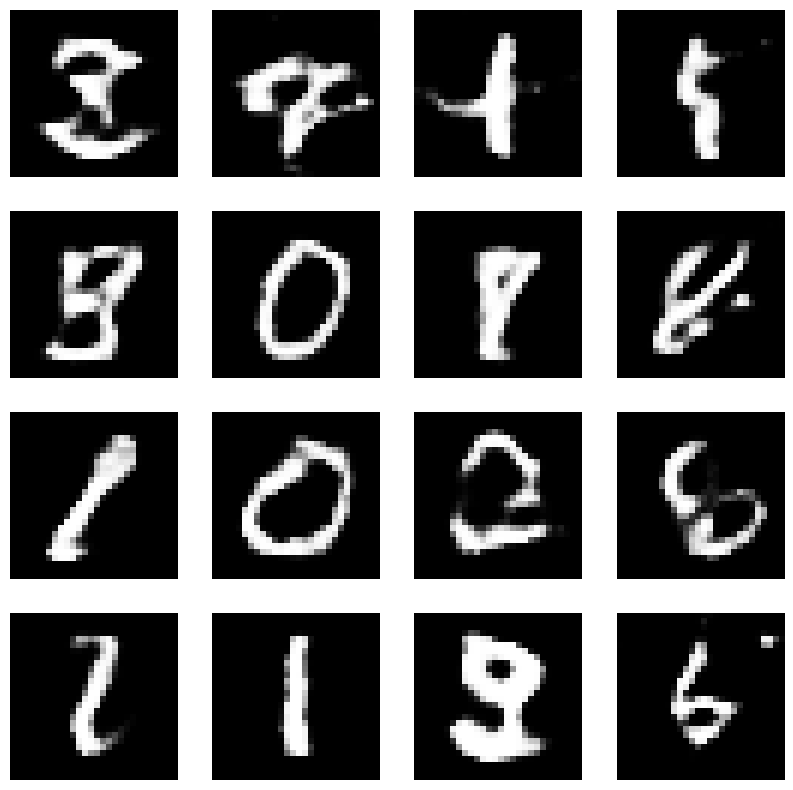

Epoch:  80


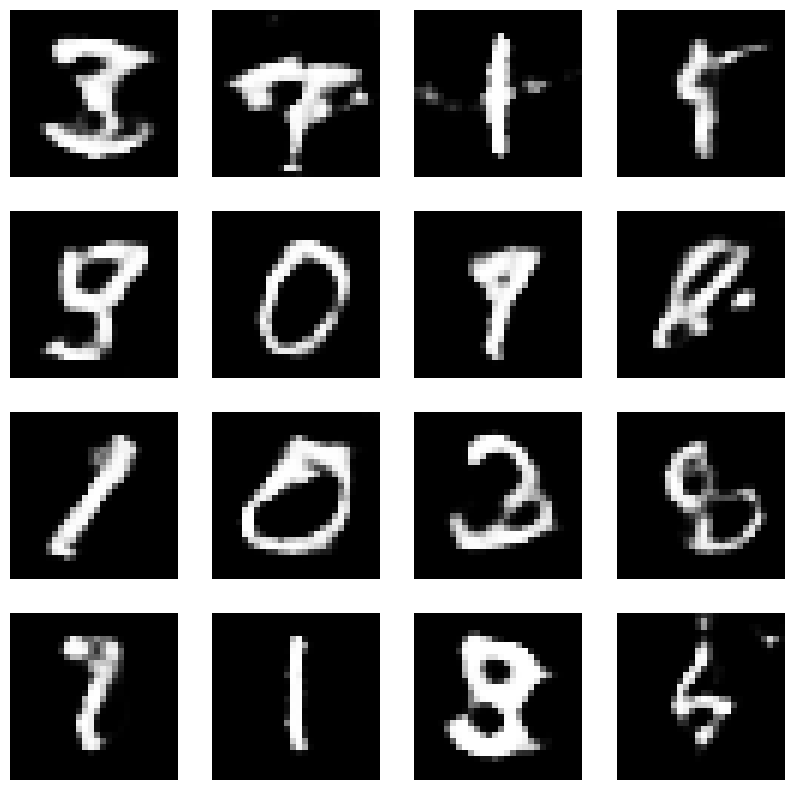

Epoch:  81


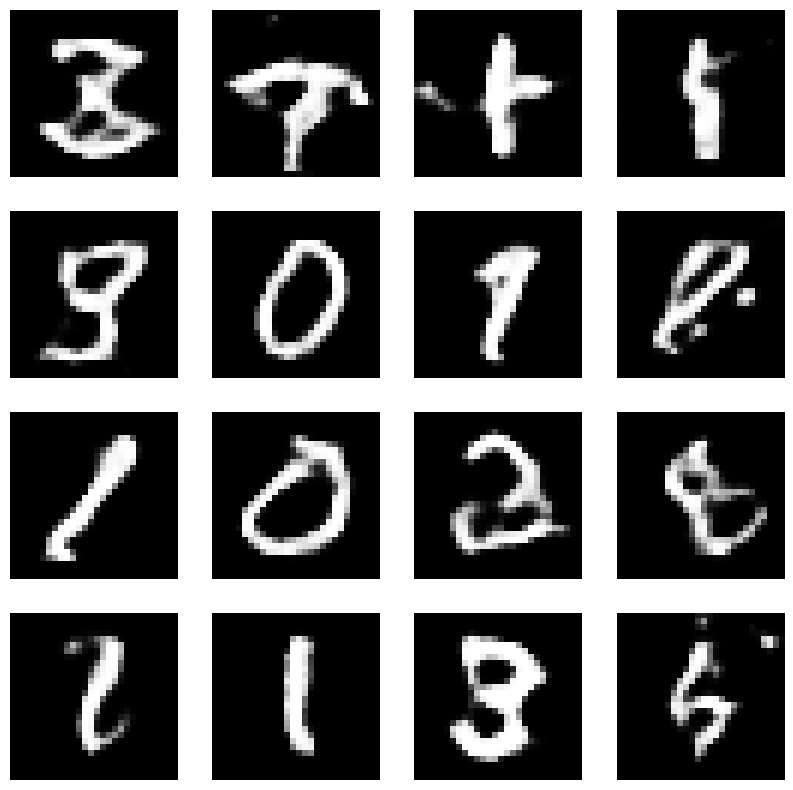

Epoch:  82


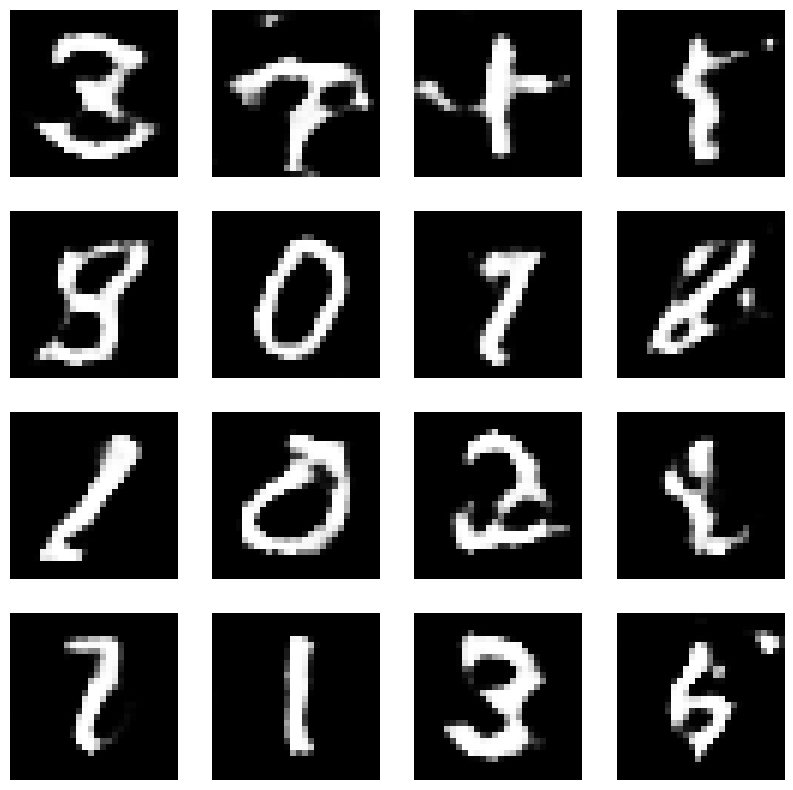

Epoch:  83


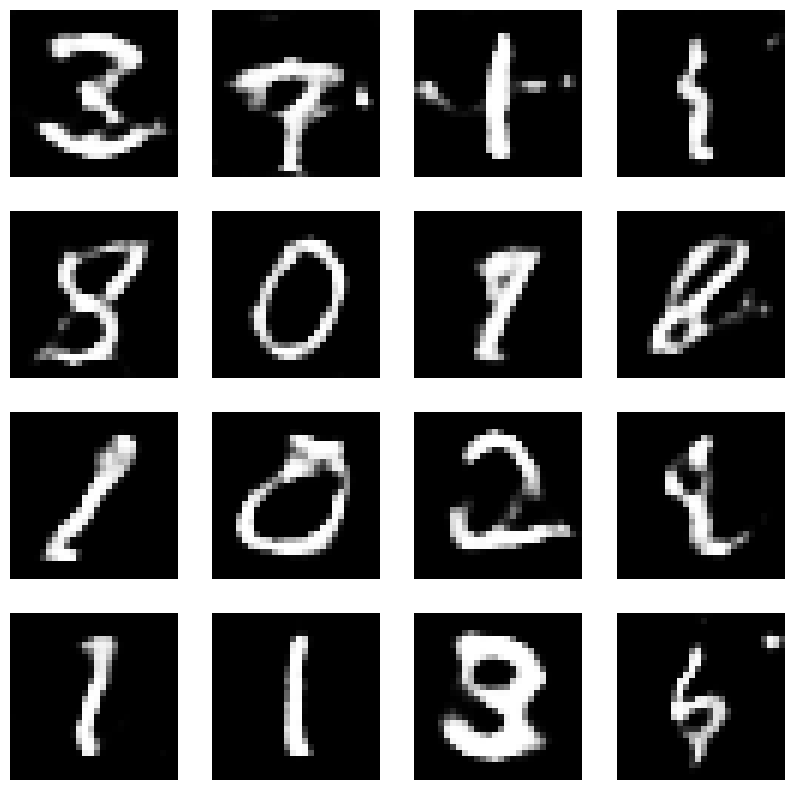

Epoch:  84


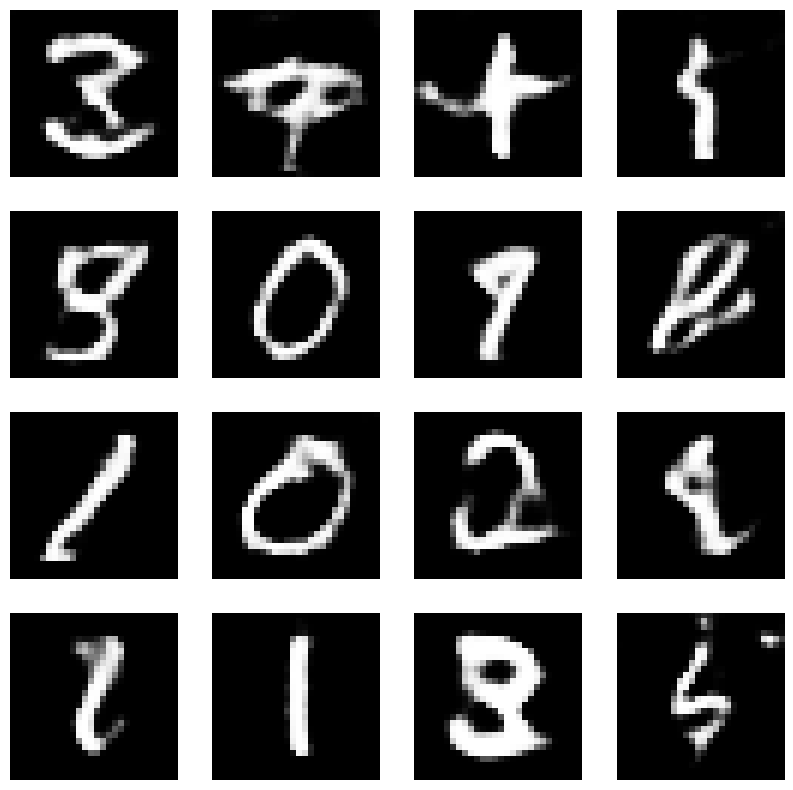

Epoch:  85


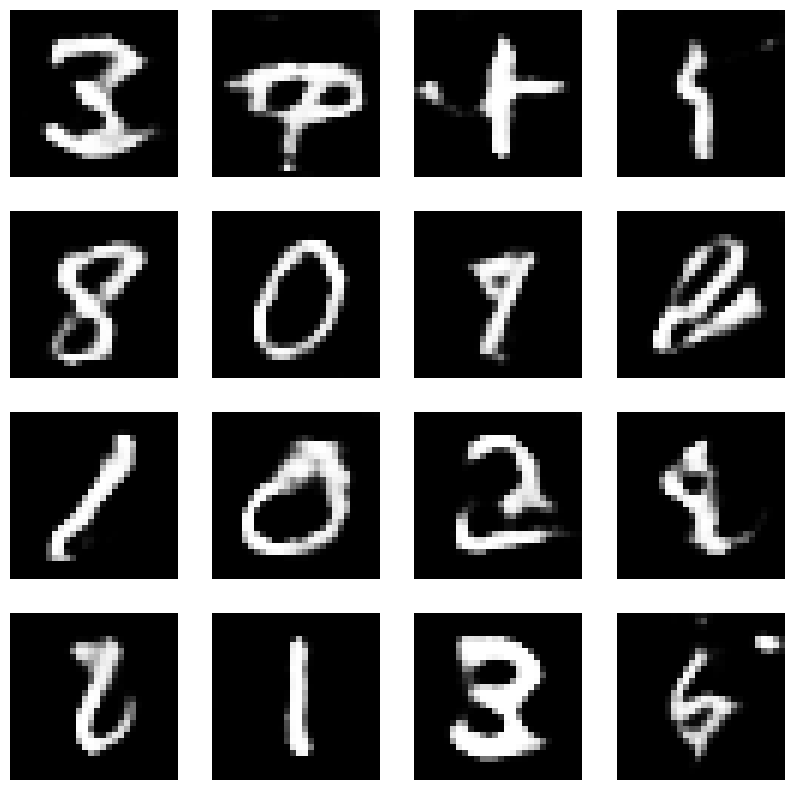

Epoch:  86


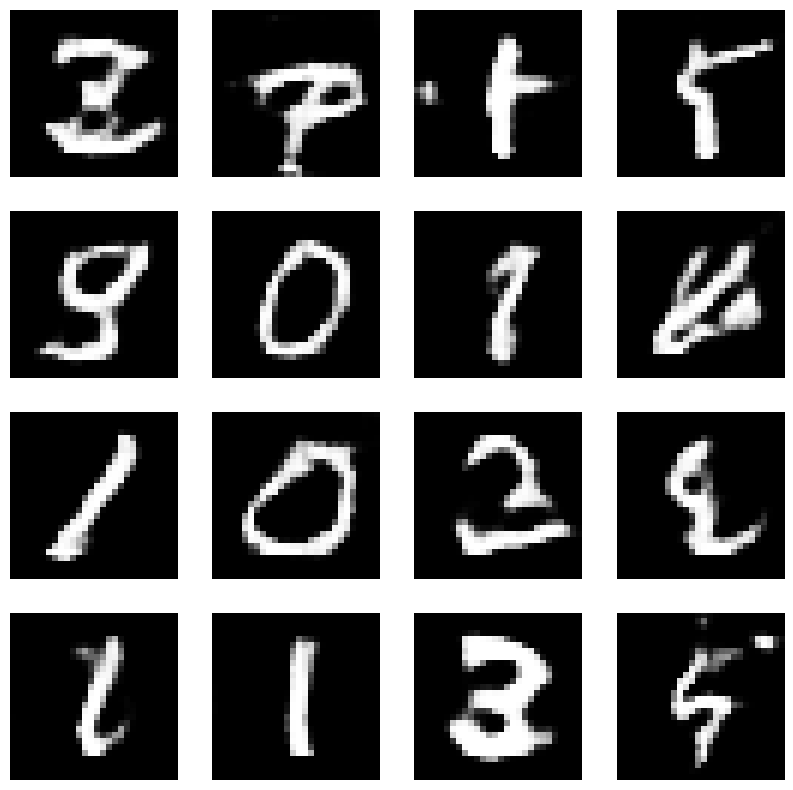

Epoch:  87


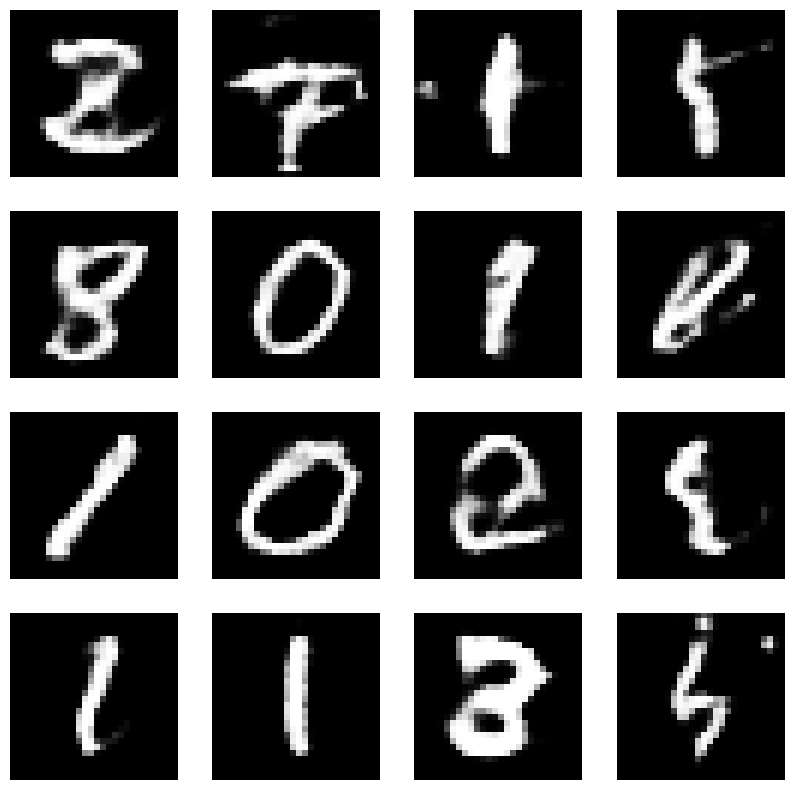

Epoch:  88


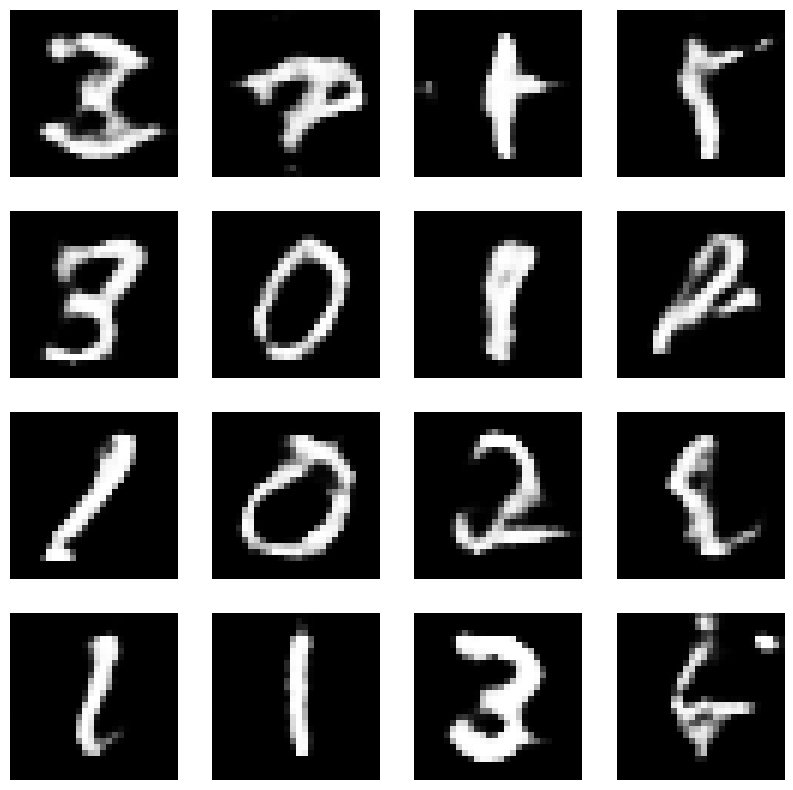

Epoch:  89


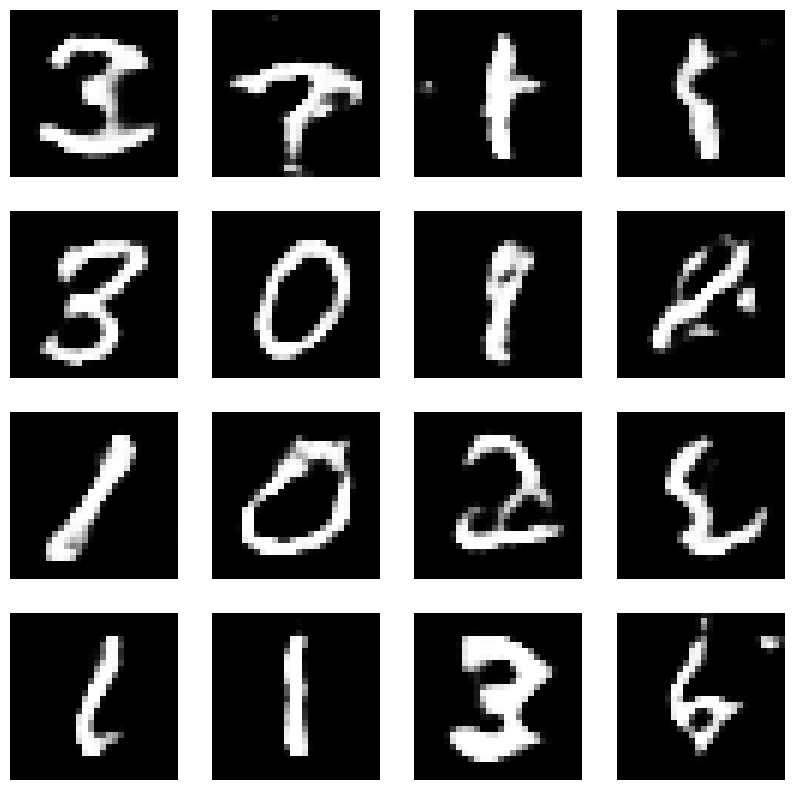

Epoch:  90


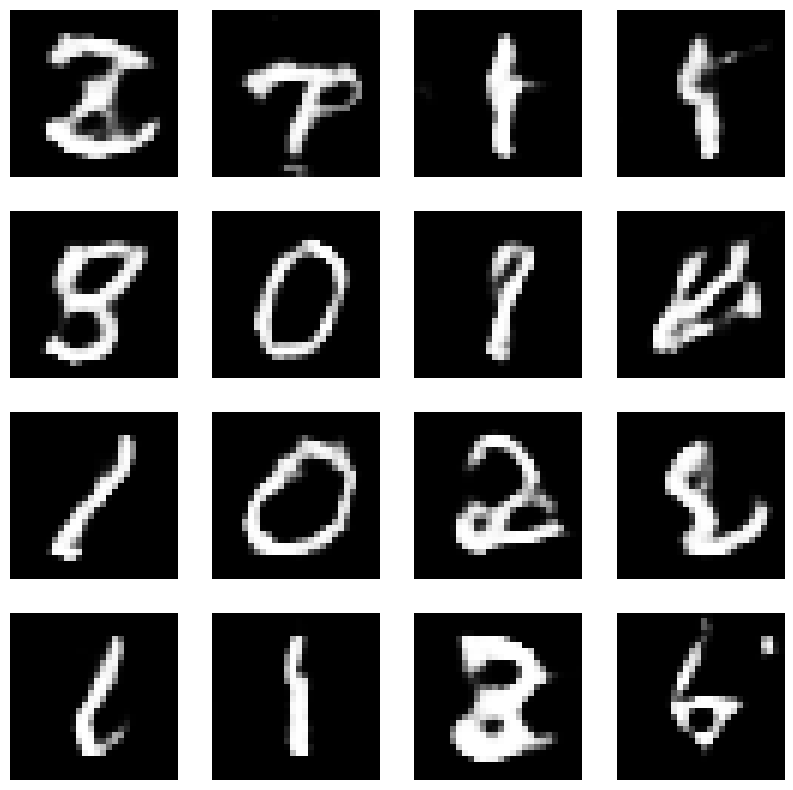

Epoch:  91


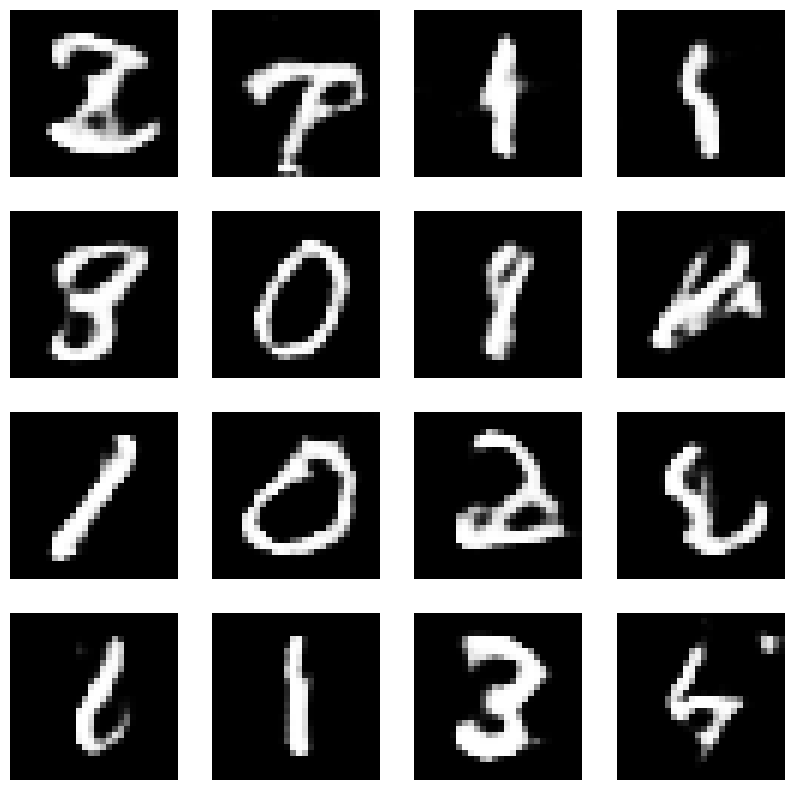

Epoch:  92


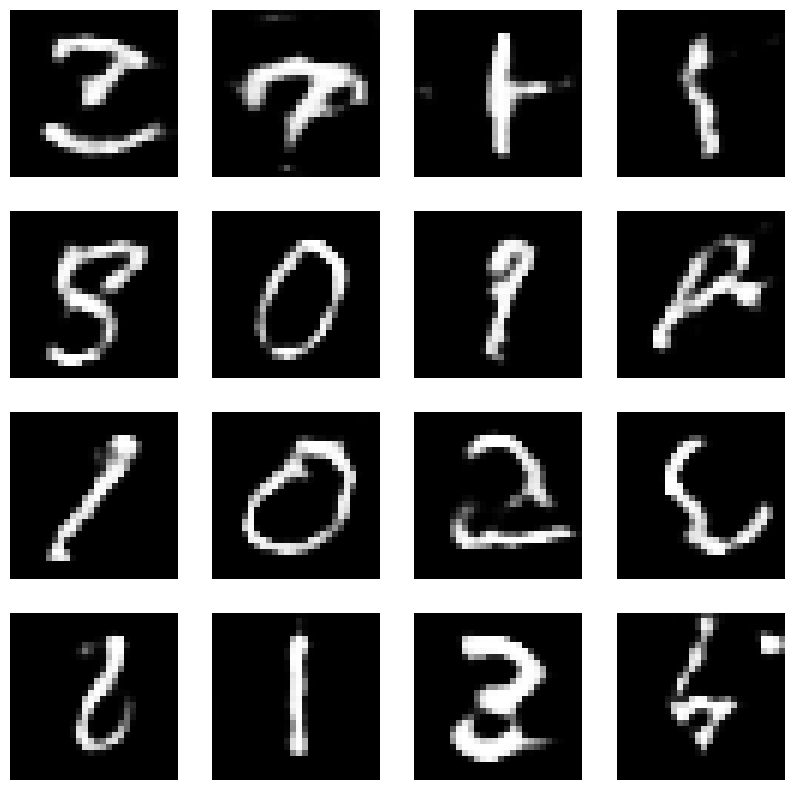

Epoch:  93


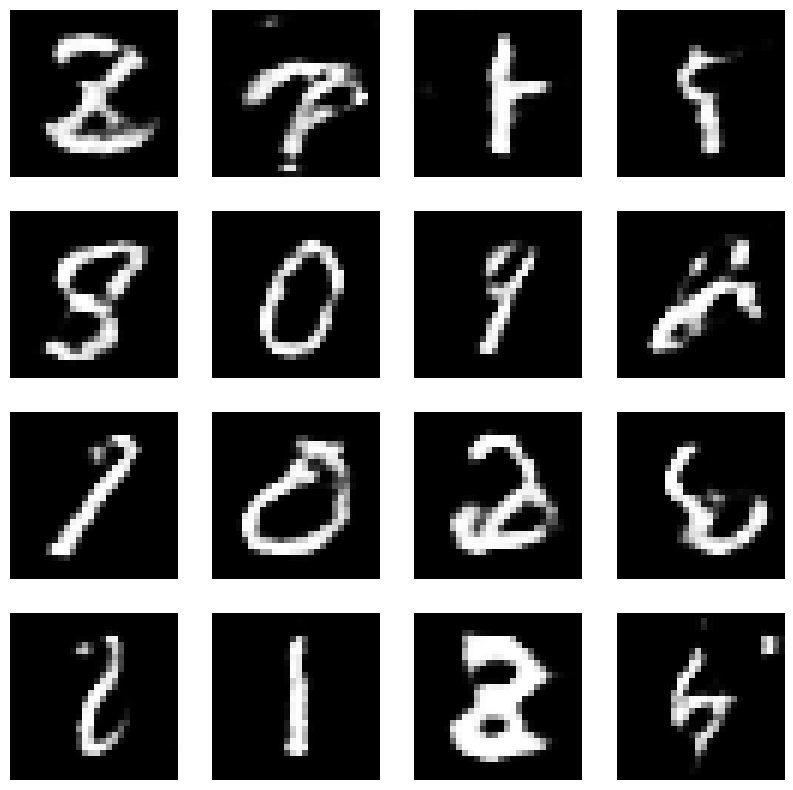

Epoch:  94


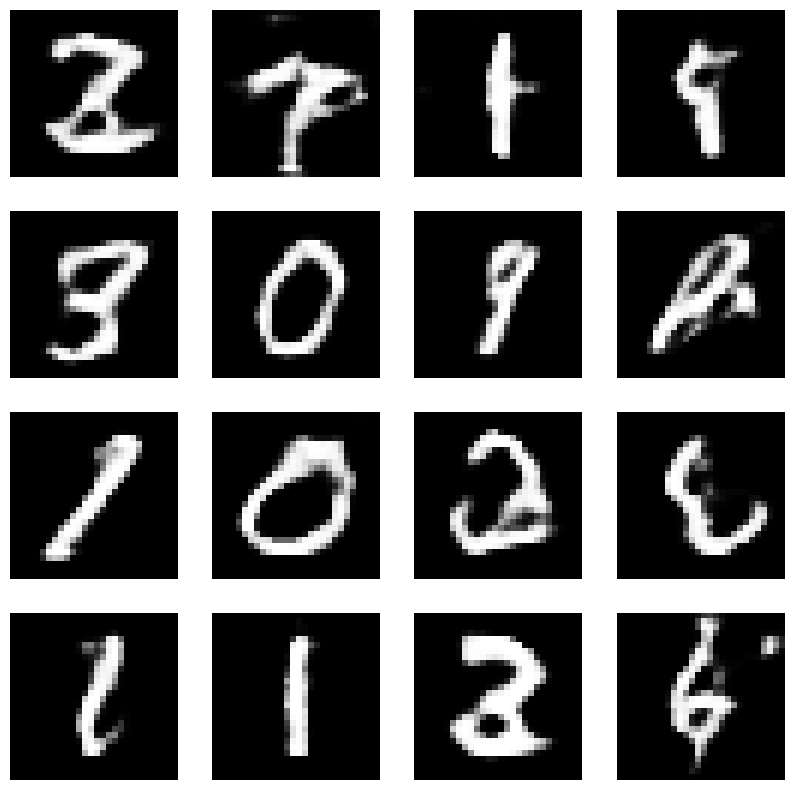

Epoch:  95


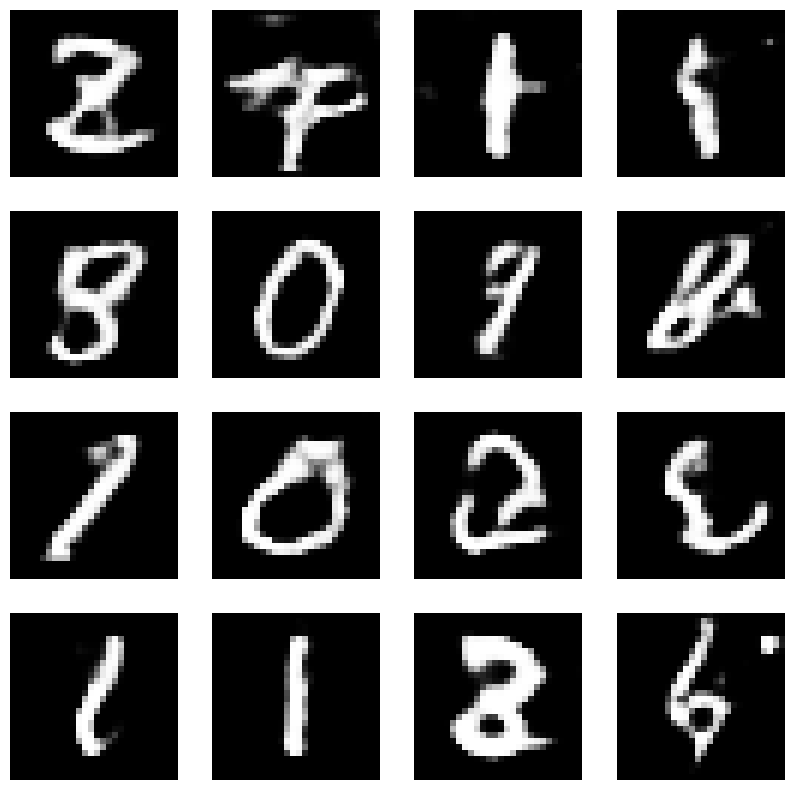

Epoch:  96


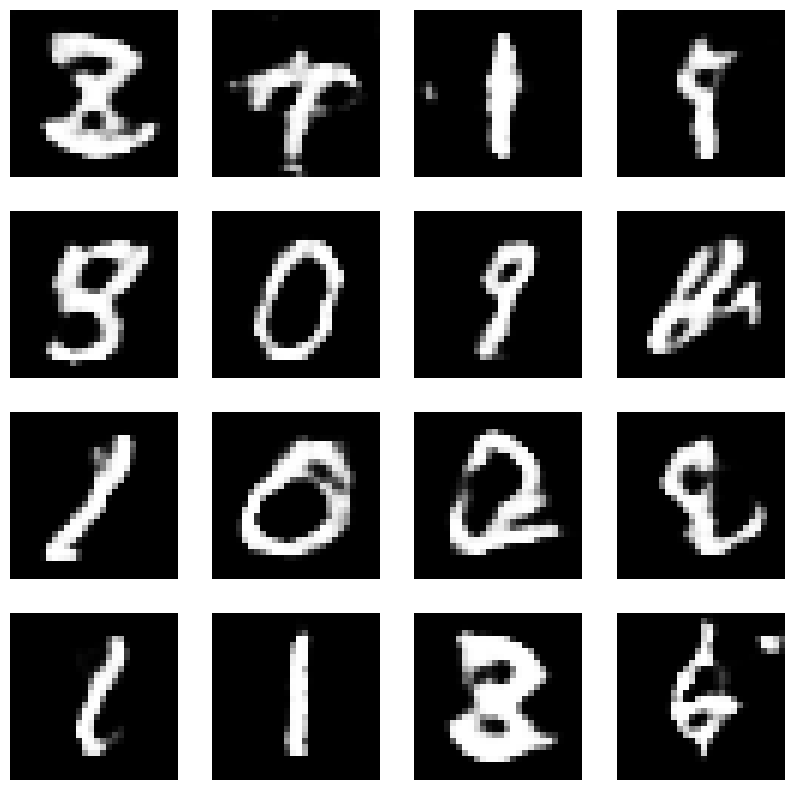

Epoch:  97


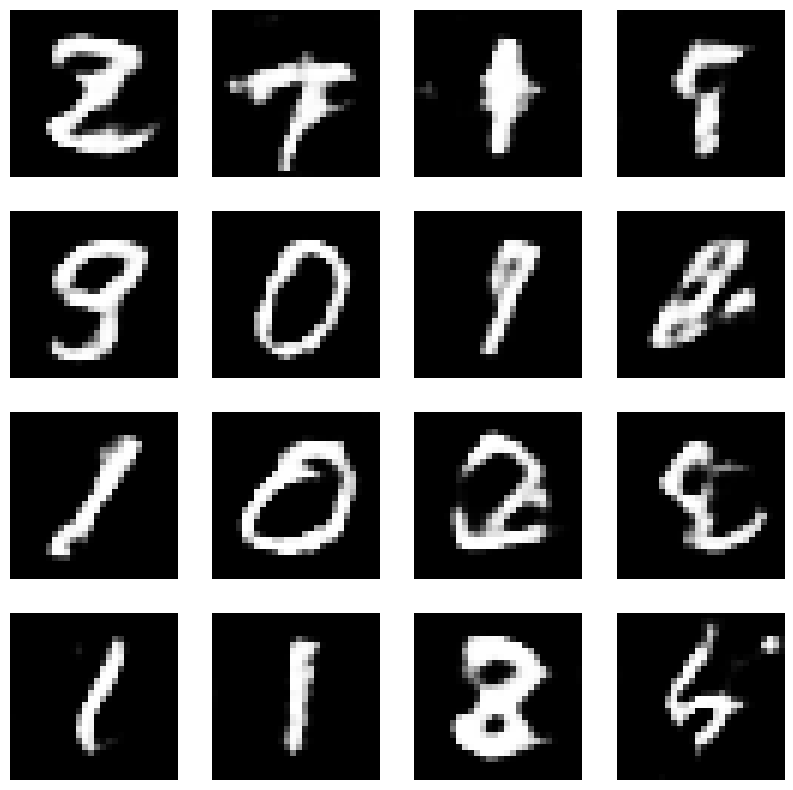

Epoch:  98


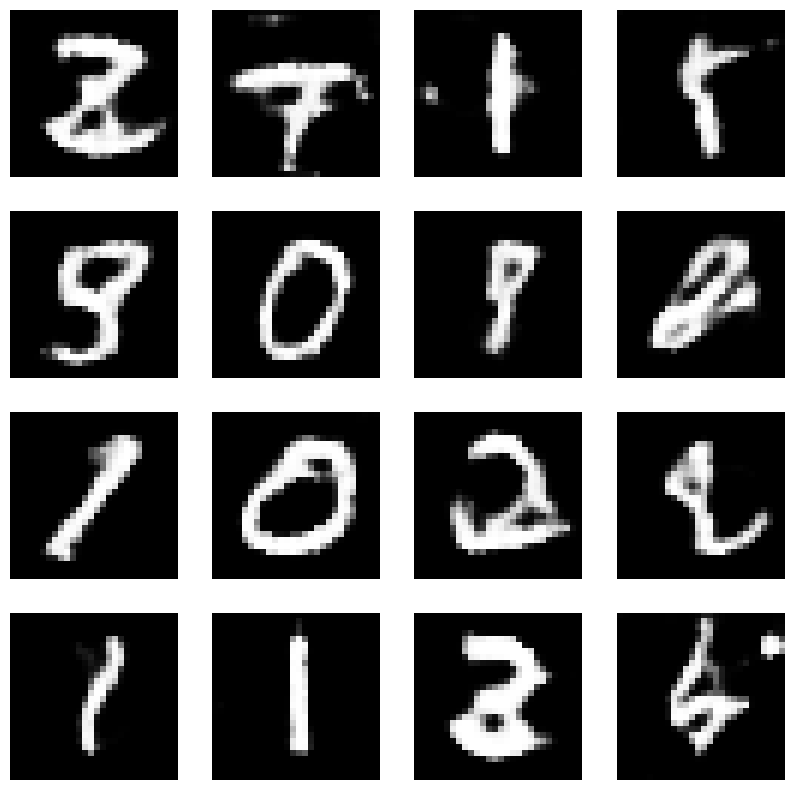

Epoch:  99


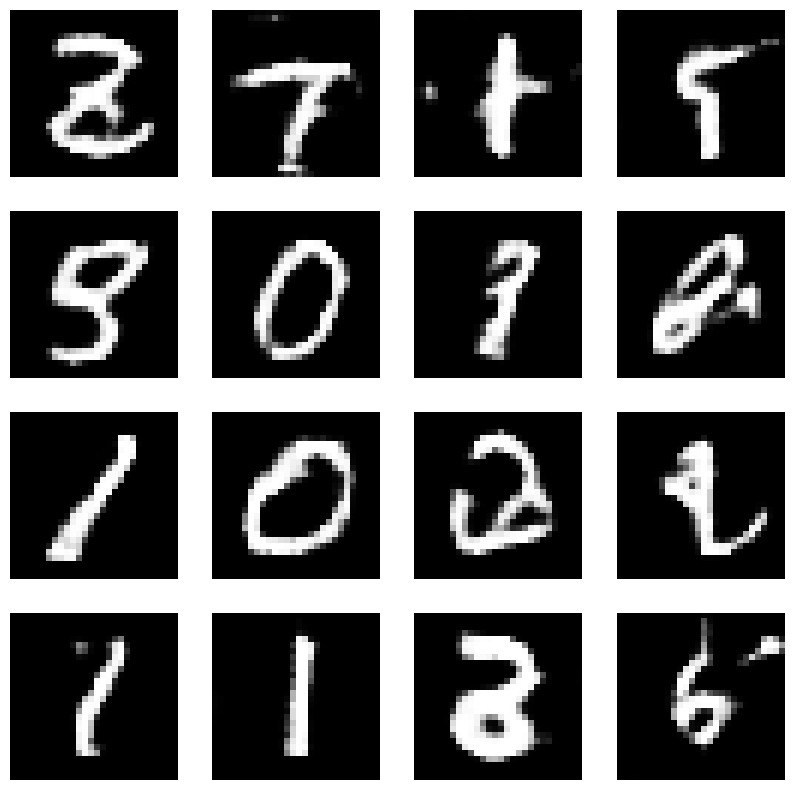

Epoch:  100


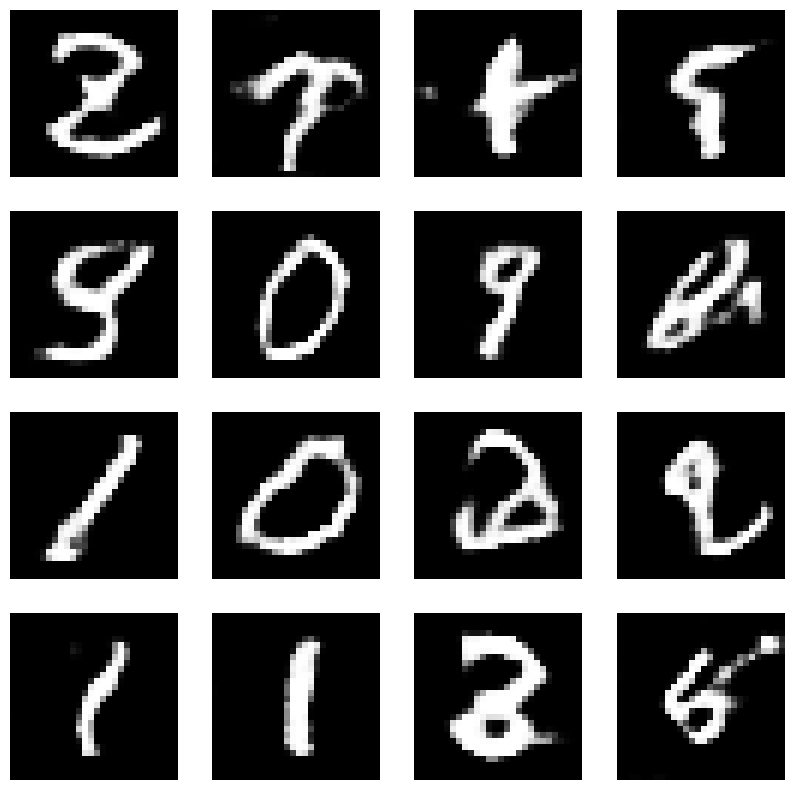

In [70]:
train_gan(X_train,epochs,test_images)